## Projet 4 : Construisez un modèle de scoring

## Contexte

Une société financière, nommée "Prêt à dépenser",  qui propose des crédits à la consommation pour des personnes ayant peu ou pas d'historique de prêt souhaite mettre en œuvre un outil de “scoring crédit” qui calcule la probabilité qu’un client le rembourse ou non, puis classifie la demande : crédit accordé ou refusé.

Elle souhaite donc développer un algorithme de classification pour aider à décider si un prêt peut être accordé à un client.

Les chargés de relation client seront les utilisateurs de l’outil de scoring. Puisqu’ils s’adressent aux clients, ils ont besoin qule e modèle soit facilement interprétable. Les chargés de relation souhaitent, en plus, disposer d’une mesure de l’importance des variables qui ont poussé le modèle à donner cette probabilité à un clienée

Notre objectif développer cet algorithme de classificationns.

## Librairies utilisées avec le langage Python:

In [8]:
# Importation des librairies
import numpy as np
from numpy import where
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC # svC car problème de classification (sinon SVR pour la regression)
from sklearn.model_selection import  GridSearchCV, cross_validate, cross_val_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.inspection import permutation_importance
from sklearn import  metrics
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score,fbeta_score,roc_auc_score,confusion_matrix,precision_recall_curve,average_precision_score
from sklearn.metrics import PrecisionRecallDisplay, make_scorer
import tensorflow as tf; tf.keras
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import Sequential
from tensorflow.keras.activations import sigmoid
from scikeras.wrappers import KerasClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import shap
import time
import os

import warnings
warnings.filterwarnings('ignore')

shap.initjs()

## Données brutes:

Nous avons 4 fichiers CSV :
- X_train : dataframe d'entrainement
- X_test : dataframe de test
- y_train : array de la variable cible pour le dataframe d'entrainement
- y_test : array de la variable cible pour le dataframe de test


In [9]:
# Chargement des données brutes du fichier CSV
X_train = pd.read_csv('/tutorial-env/OCR/Projet 4/X_train.csv')
X_test = pd.read_csv('/tutorial-env/OCR/Projet 4/X_test.csv')
y_train = pd.read_csv('/tutorial-env/OCR/Projet 4/y_train.csv')
y_test = pd.read_csv('/tutorial-env/OCR/Projet 4/y_test.csv')


## Normalisation et équilibrage des données:

Afin que les différents ordres de grandeur des variables n'impactent pas les résultats des modèles, normalisons les données pour que chaque variable ait une moyenne égale à 0 et une variance égale à 1.

In [11]:
# Créer une instance de Standardscaler
scaler = StandardScaler()

# Normalisation des données (entrainement de l'imputer seulement sur les données d'entrainement pour éviter la fuite de données)
X_train_norm = pd.DataFrame(
        scaler.fit_transform(X_train),
        columns=X_train.columns,
    )
X_test_norm = pd.DataFrame(
        scaler.transform(X_test),
        columns=X_test.columns,
    )

# Save the processed data
X_train_norm.to_csv('C:/tutorial-env/OCR/Projet 4/X_train_norm.csv', index=False)
X_test_norm.to_csv('C:/tutorial-env/OCR/Projet 4/X_test_norm.csv', index=False)

X_train_norm.describe(include="all")

,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,...,EXT_SOURCE_2 EXT_SOURCE_3 AGE,EXT_SOURCE_2 AGE^2,EXT_SOURCE_3^3,EXT_SOURCE_3^2 AGE,EXT_SOURCE_3 AGE^2,AGE^3,CREDIT_INCOME_PERCENT,ANNUITY_INCOME_PERCENT,CREDIT_TERM,DAYS_EMPLOYED_PERCENT
count,2.460080e+05,2.460080e+05,2.460080e+05,2.460080e+05,2.460080e+05,2.460080e+05,2.460080e+05,2.460080e+05,2.460080e+05,2.460080e+05,...,2.460080e+05,2.460080e+05,2.460080e+05,2.460080e+05,2.460080e+05,2.460080e+05,2.460080e+05,2.460080e+05,2.460080e+05,2.460080e+05
mean,-2.439162e-17,7.619312e-17,8.231630e-19,3.685460e-17,-7.635198e-17,-1.525018e-17,1.060725e-16,-1.396344e-16,2.105203e-16,7.849653e-17,...,1.709796e-16,-2.103651e-16,-1.855727e-18,-2.944577e-16,-1.365801e-16,-2.082620e-16,-1.352081e-16,-5.978041e-17,3.463206e-16,2.082169e-16
std,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,...,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00
min,-3.240958e-01,-7.181065e-01,-1.504488e+00,-5.783884e-01,-1.290830e+00,-1.375004e+00,-1.730469e+00,-1.346725e+00,-1.486146e+00,-7.333252e+00,...,-1.584741e+00,-1.497664e+00,-1.287505e+00,-1.476073e+00,-1.490155e+00,-1.235105e+00,-1.457086e+00,-1.879552e+00,-1.405597e+00,-1.231423e+00
25%,-3.240958e-01,-7.181065e-01,-1.504488e+00,-5.783884e-01,-5.058207e-01,-8.169786e-01,-7.290435e-01,-8.114375e-01,-7.848350e-01,-2.383158e-01,...,-7.856344e-01,-7.900509e-01,-7.725323e-01,-7.364425e-01,-7.993859e-01,-8.372509e-01,-7.210562e-01,-6.992557e-01,-7.463803e-01,-6.700315e-01
50%,-3.240958e-01,-7.181065e-01,6.646779e-01,-5.783884e-01,-1.926305e-01,-2.099033e-01,-1.517986e-01,-2.396532e-01,-1.464656e-01,2.824135e-01,...,-1.340934e-01,-2.146505e-01,-1.990798e-01,-1.531426e-01,-2.300039e-01,-3.072610e-01,-2.560827e-01,-1.901808e-01,-1.636806e-01,-2.570554e-01
75%,-3.240958e-01,1.392551e+00,6.646779e-01,8.060206e-01,3.076604e-01,5.189330e-01,5.153019e-01,3.807937e-01,5.618471e-01,6.177032e-01,...,6.488994e-01,6.323189e-01,5.270975e-01,5.402718e-01,6.218266e-01,6.861110e-01,4.491536e-01,5.080589e-01,4.603361e-01,3.359937e-01
max,3.085507e+00,1.392551e+00,6.646779e-01,2.572538e+01,1.611744e+02,8.557840e+00,1.589951e+01,9.492847e+00,3.726626e+00,1.054610e+00,...,4.465937e+00,3.792343e+00,3.817575e+00,4.271825e+00,3.986507e+00,2.935865e+00,3.000983e+01,1.794113e+01,3.146161e+00,4.749540e+00


Pour éliminer un biais dans l'apprentissage de nos modèles, ocupons-nous maintenant du rééquilibrage des données avec la méthode SMOTE (Synthetic Minority Oversampling Technique) qui va créer de nouveaux exemples de la classe minoritaires plausibles d'après les exemples actuels de la classe minoritaire.

In [12]:
y_train.shape

(246008, 1)

In [13]:
# Méthode SMOTE pour l'équilibrage des données
oversample = SMOTE()
X_train_eq, y_train_eq = oversample.fit_resample(X_train_norm, y_train)

Comparons la différence de distribution de notre variable cible avant et après la méthode SMOTE :

<Axes: title={'center': 'Distribution de la variable cible "TARGET" initial'}, xlabel='TARGET_x', ylabel='count'>

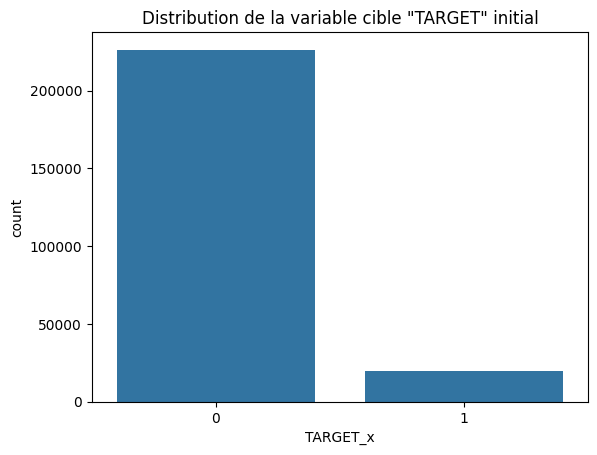

In [14]:
plt.title(f'Distribution de la variable cible "TARGET" initial')
sns.countplot(y_train, x="TARGET_x")

<Axes: title={'center': 'Distribution de la variable cible "TARGET"après SMOTE'}, xlabel='TARGET_x', ylabel='count'>

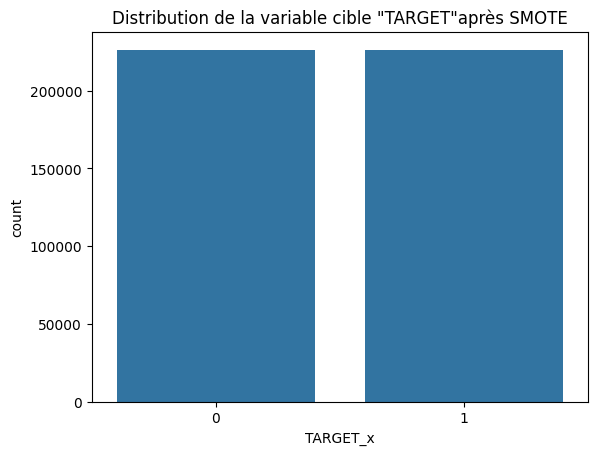

In [15]:
plt.title(f'Distribution de la variable cible "TARGET"après SMOTE')
sns.countplot(y_train_eq, x="TARGET_x")

In [16]:
y_train_eq.shape

(452438, 1)

Nos données d'entrainements sont bien équilibrées, cependant, le nombre de lignes de notre dataframe est significativment plus important et va induire des temps d'apprentissage et d'éxécution trop longs.

Testons donc une méthode qui qui supprimera des éléments de la classe majoritaire à la place avec la fonction RandomUnderSampler:


In [17]:
rus = RandomUnderSampler(random_state=42)
X_train_eq, y_train_eq = rus.fit_resample(X_train_norm, y_train)

<Axes: title={'center': 'Distribution de la variable cible "TARGET" après RandomUnderSampler'}, xlabel='TARGET_x', ylabel='count'>

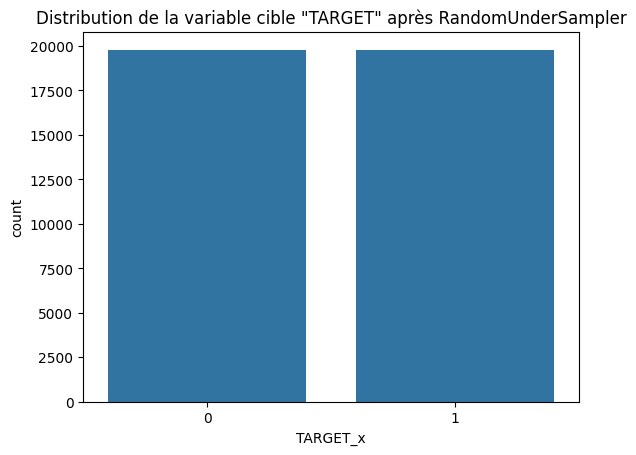

In [18]:
plt.title(f'Distribution de la variable cible "TARGET" après RandomUnderSampler')
sns.countplot(y_train_eq, x="TARGET_x")

In [19]:
y_train_eq.shape

(39578, 1)


 Nos données d'entrainements sont bien équilibrées et le nombre de lignes est beaucoup plus petite ce qui va nous permettre de pouvoir faire tourner nos algorithmes plus rapidement.

 Bien entendu, nous laissons les données de tests déséquilibrées puisqu'elles doivent refléter la réalité.

## Modélisation et évaluation:

Nous allons tester différents modèles de classification binaire et évaluer leur efficacité en terme de performances et de temps d'entainement et d'exécution.

Pour l'évaluation des performances nous allons calculer différentes métriques :
- l'accuracy (efficacité d'un modèle à prédire correctement à la fois les individus positifs et négatifs)
- la précision (nombre de positifs bien prédit (Vrai Positif) divisé par l’ensemble des positifs prédit)
- le recall (nombre de positifs bien prédit (VP) divisé par l’ensemble des positifs)
- le F1 score (moyenne harmonique du recall et de la precision)
- le F beta score (avec beta>1, pour accorder plus d’importance au recall (autrement dit aux Faux Négatif) puisque la prédiction des difficultés de remboursement est plus importante pour l'entreprise. En effet, les FN coûtent plus d'argent que les Faux Positifs.)
- l'aire sous la courbe ROC (relation entre spécificité et sensibilité)
- l'aire sous la courbe PR (relation entre précision et recall)

### Modèle de base :

Notre modèle de base va effectuer des prédictions basées sur la valeur de la variable la plus fréquente.

In [20]:
#Entrainement du classifieur
clf = DummyClassifier(strategy=  "most_frequent",random_state=42).fit(X_train_eq,y_train_eq)

#Prédiction de la variable cible sur la base de données test
y_pred = clf.predict(X_test_norm)
y_pred_proba = clf.predict_proba(X_test_norm)[:, 1]

#Distribution de la variable cible sur la base de données test
print('y réel : \n' +  str(y_test.value_counts())+'\n')

#Distribution de la variable cible prédite
print('y prédit: \n' + str(pd.Series(y_pred).value_counts()))

y réel : 
TARGET_x
0           56467
1            5036
Name: count, dtype: int64

y prédit: 
0    61503
Name: count, dtype: int64


In [21]:
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred))) #si problème de régression, remplacé par R²
print('Precision Score : ' + str(precision_score(y_test,y_pred)))
print('Recall Score : ' + str(recall_score(y_test,y_pred)))
print('F1 Score : ' + str(f1_score(y_test,y_pred)))
print('F beta Score (avec beta=2) : ' + str(fbeta_score(y_test,y_pred, beta=2)))
print('Aire sous la courbe ROC : ' +str(roc_auc_score(y_test,y_pred)))
print('Aire sous la courbe PR : ' +str(average_precision_score(y_test, y_pred_proba)))

Accuracy Score : 0.9181178153911191
Precision Score : 0.0
Recall Score : 0.0
F1 Score : 0.0
F beta Score (avec beta=2) : 0.0
Aire sous la courbe ROC : 0.5
Aire sous la courbe PR : 0.08188218460888087


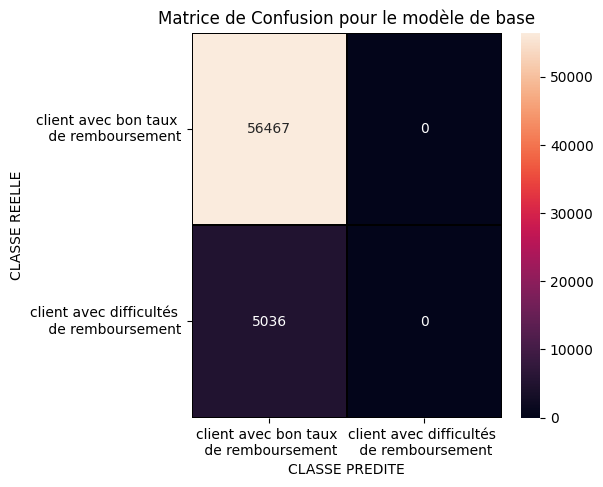

In [22]:
# Graphique de la matrice de confusion
cm = confusion_matrix(y_test, y_pred)

x_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
y_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm, annot=True, linewidths=0.2, linecolor="black",
                fmt=".0f", ax=ax,
                xticklabels=x_axis_labels,
                yticklabels=y_axis_labels)
plt.yticks(rotation=0)
plt.ylabel("CLASSE REELLE")
plt.xlabel("CLASSE PREDITE")
plt.title('Matrice de Confusion pour le modèle de base')
plt.show()

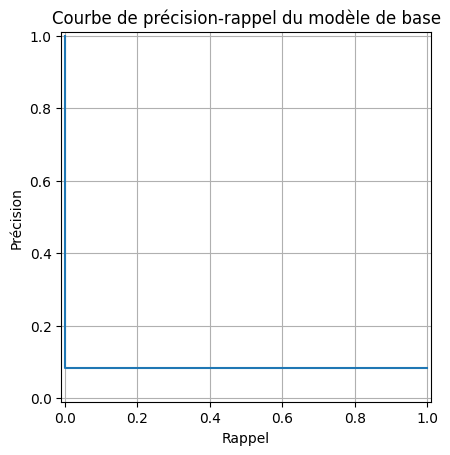

In [23]:
# Graphique précision-rappel
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.xlabel('Rappel')
plt.ylabel('Précision')
plt.title('Courbe de précision-rappel du modèle de base')
plt.grid(True)
plt.show()

Text(0.5, 1.0, 'Courbe ROC du modèle de base')

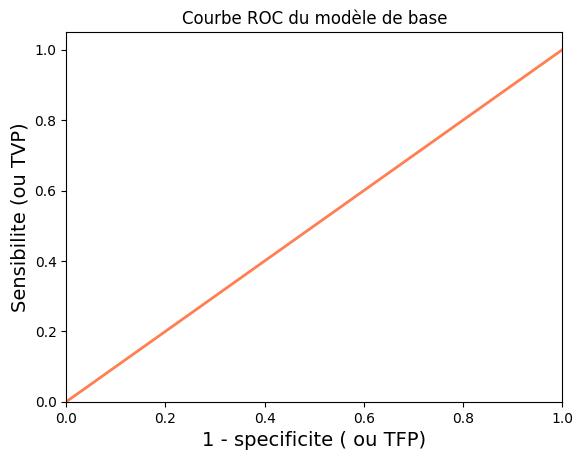

In [24]:
# Graphique courbe ROC
[fpr, tpr, thr] = metrics.roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, color='coral', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - specificite ( ou TFP)', fontsize=14)
plt.ylabel('Sensibilite (ou TVP)', fontsize=14)
plt.title('Courbe ROC du modèle de base')

Nous voyons que prédire la classe la plus représentée (ici 0) permet d'obtenir une bonne accuracy mais des résultats médiocres pour tous les autres scores.

De plus, il n'y a aucune minimisation des FN puisque toutes les prédictions sont égales à 0 donc avec un bon taux de remboursement. Or c'est ce que l'on souhaite obtenir !

### Modèles linéaires de régression logistique :

Le modèle de régression logistique est un modèle simple qui analyse les relations entre une variable cible binaire et l’ensemble des autres variables indépendantes. Cette relation est exprimée comme une équation qui prédit la probabilité de réalisation des deux classes de la variable cible comme une combinaison linéaire de paramètres suivant une fonction logistique.


In [25]:
# Création d'une instance de modèle de régression logistique
lr = LogisticRegression(solver="saga",max_iter=1000,n_jobs=-1,random_state=42)

# On entraîne ce modèle sur les données d'entrainement
lr.fit(X_train_eq,y_train_eq)
y_pred_lr = lr.predict(X_test_norm)
y_pred_lr_prob = lr.predict_proba(X_test_norm)[:, 1]


In [26]:
# score de la régression logistique
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_lr)))
print('Precision Score : ' + str(precision_score(y_test,y_pred_lr)))
print('Recall Score : ' + str(recall_score(y_test,y_pred_lr)))
print('F1 Score : ' + str(f1_score(y_test,y_pred_lr)))
print('F beta Score (avec beta=3) : ' + str(fbeta_score(y_test,y_pred_lr, beta=3)))
print('Aire sous la courbe ROC : ' +str(roc_auc_score(y_test,y_pred_lr)))
print('Aire sous la courbe PR : ' +str(average_precision_score(y_test, y_pred_lr_prob)))

Accuracy Score : 0.6845357137050225
Precision Score : 0.1625481537160575
Recall Score : 0.687053216838761
F1 Score : 0.26289795608236455
F beta Score (avec beta=3) : 0.519441525296502
Aire sous la courbe ROC : 0.685682203722832
Aire sous la courbe PR : 0.22278308239428082


In [27]:
lr = LogisticRegression(solver="saga", penalty='elasticnet',max_iter=200, n_jobs=-1,random_state=42)
params = {'C': np.logspace(-5, 5, 10),"l1_ratio": np.linspace(0, 1, 10)}

# optimisation des paramètres avec la grid search
grid_lr = GridSearchCV(lr, params,cv=3, n_jobs=-1)
grid_lr.fit(X_train_eq,y_train_eq)

#récupération des meilleurs hyperparamètres
best_model_lr_gs = grid_lr.best_estimator_

In [28]:
print(best_model_lr_gs)

LogisticRegression(C=0.021544346900318846, l1_ratio=0.4444444444444444,
                   max_iter=200, n_jobs=-1, penalty='elasticnet',
                   random_state=42, solver='saga')


In [29]:
cvres_lr=pd.DataFrame(grid_lr.cv_results_)
cvres_lr

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_l1_ratio,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,2.879234,0.128145,0.036693,0.003790,0.00001,0.000000,"{'C': 1e-05, 'l1_ratio': 0.0}",0.664898,0.666414,0.673969,0.668427,0.003967,80
1,0.744761,0.083991,0.054187,0.002639,0.00001,0.111111,"{'C': 1e-05, 'l1_ratio': 0.1111111111111111}",0.499962,0.500038,0.500000,0.500000,0.000031,88
2,0.568782,0.031886,0.050506,0.009496,0.00001,0.222222,"{'C': 1e-05, 'l1_ratio': 0.2222222222222222}",0.499962,0.500038,0.500000,0.500000,0.000031,88
3,0.447344,0.010307,0.032992,0.002801,0.00001,0.333333,"{'C': 1e-05, 'l1_ratio': 0.3333333333333333}",0.499962,0.500038,0.500000,0.500000,0.000031,88
4,0.348002,0.091565,0.043195,0.009630,0.00001,0.444444,"{'C': 1e-05, 'l1_ratio': 0.4444444444444444}",0.499962,0.500038,0.500000,0.500000,0.000031,88
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,26.694753,0.172687,0.044859,0.004695,100000.00000,0.555556,"{'C': 100000.0, 'l1_ratio': 0.5555555555555556}",0.677480,0.675889,0.686325,0.679898,0.004591,16
96,26.372640,0.307616,0.041463,0.008173,100000.00000,0.666667,"{'C': 100000.0, 'l1_ratio': 0.6666666666666666}",0.677480,0.675889,0.686325,0.679898,0.004591,16
97,25.710886,0.740905,0.032390,0.002330,100000.00000,0.777778,"{'C': 100000.0, 'l1_ratio': 0.7777777777777777}",0.677480,0.675889,0.686325,0.679898,0.004591,16
98,24.280568,0.348572,0.030001,0.001453,100000.00000,0.888889,"{'C': 100000.0, 'l1_ratio': 0.8888888888888888}",0.677480,0.675889,0.686325,0.679898,0.004591,16


In [30]:
cols= [i for i in cvres_lr.columns if "split" not in i ]
cvres_lr=cvres_lr [cols].sort_values("rank_test_score")
cvres_lr.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_l1_ratio,params,mean_test_score,std_test_score,rank_test_score
34,26.480228,0.197098,0.061645,0.009284,0.021544,0.444444,"{'C': 0.021544346900318846, 'l1_ratio': 0.4444...",0.680656,0.004330,1
35,26.503662,0.233180,0.051977,0.008506,0.021544,0.555556,"{'C': 0.021544346900318846, 'l1_ratio': 0.5555...",0.680504,0.004547,2
31,28.140998,0.262666,0.043898,0.000547,0.021544,0.111111,"{'C': 0.021544346900318846, 'l1_ratio': 0.1111...",0.680378,0.003617,3
49,33.230145,0.813354,0.076762,0.009327,0.278256,1.000000,"{'C': 0.2782559402207126, 'l1_ratio': 1.0}",0.680328,0.004514,4
33,27.431273,0.469088,0.053268,0.003457,0.021544,0.333333,"{'C': 0.021544346900318846, 'l1_ratio': 0.3333...",0.680252,0.004057,5
32,27.341406,0.089673,0.053439,0.006024,0.021544,0.222222,"{'C': 0.021544346900318846, 'l1_ratio': 0.2222...",0.680151,0.004008,6
30,20.094097,0.627613,0.069723,0.030866,0.021544,0.000000,"{'C': 0.021544346900318846, 'l1_ratio': 0.0}",0.680151,0.003972,7
44,33.431780,3.832381,0.074334,0.005403,0.278256,0.444444,"{'C': 0.2782559402207126, 'l1_ratio': 0.444444...",0.680125,0.004456,8
45,35.556329,2.119970,0.063551,0.017061,0.278256,0.555556,"{'C': 0.2782559402207126, 'l1_ratio': 0.555555...",0.680100,0.004364,9
48,31.630028,2.488831,0.062984,0.006519,0.278256,0.888889,"{'C': 0.2782559402207126, 'l1_ratio': 0.888888...",0.680075,0.004478,10


Les hyperparamètres optimisés correspondent au couple {'C': 0.021544, 'l1_ratio': 0.444444	} et entrainent une maximisation  du mean_test_score égal à 0.680656.


Maintenant, cherchons à optimiser le seuil de décision de l'algorithme en cherchant à minimiser au maximum le taux de FN, donc en maximisant le recall ou,ici, le f beta score avec beta =3.

In [31]:
# prédiction sur les données d'entrainement avec les meilleurs hyperparamètres
y_prob_train_lr_gd = best_model_lr_gs.predict_proba(X_train_eq)[:, 1]
y_pred_train_lr_gd = best_model_lr_gs.predict(X_train_eq)

In [32]:
# F3 score selon les différents seuils de décision
f3_score_lr=[]
for i in [x / 100.0 for x in range(0, 100, 1)]:
  preds=(np.where(y_prob_train_lr_gd > i, 1, 0))
  f3_score_lr.append(str(fbeta_score(y_train_eq,preds, beta=3)))


In [33]:
df=pd.DataFrame(data={'abs': [x / 100.0 for x in range(0, 100, 1)], 'f3_score': f3_score_lr})
df['f3_score']=df['f3_score'].astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   abs       100 non-null    float64
 1   f3_score  100 non-null    float64
dtypes: float64(2)
memory usage: 1.7 KB


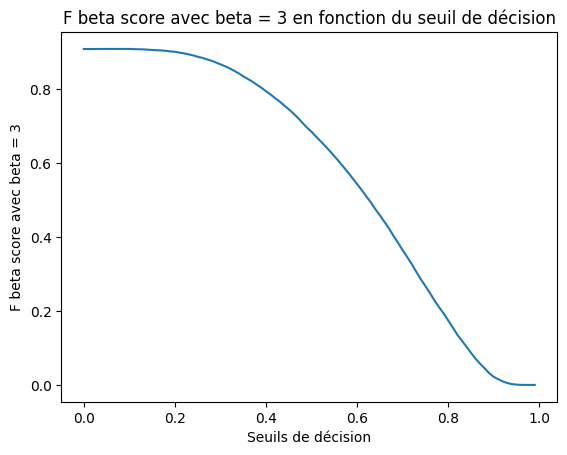

In [34]:
# Affichage des valeurs du F3 score en fonction des différents seuils de décision
plt.plot(df['abs'], df['f3_score'])
plt.title('F beta score avec beta = 3 en fonction du seuil de décision')
plt.xlabel('Seuils de décision')
plt.ylabel('F beta score avec beta = 3')
plt.show()

La solution visuelle n'est pas suffisante pour trouver le bon seuil, cherchons sa valeur numérique.

In [35]:
# Cherchons la valeur maximale du F3 score
f3_score_lr_max=df['f3_score'].max()
# Cherchons la valeur du seuil correspondant au F3 score max
seuil_opt_lr=df.loc[df['f3_score']==f3_score_lr_max,['abs']]
seuil_opt_lr=seuil_opt_lr.values[0,0]
seuil_opt_lr

0.07

In [36]:
# Récupération des prédictions correspondantes au nouveau seuil de décision
y_lr_opt=(y_prob_train_lr_gd> seuil_opt_lr).astype(int)

In [38]:
# score de la régression logistique avec seuil de décision optimisé
print('Accuracy Score : ' + str(accuracy_score(y_train_eq,y_lr_opt)))
print('Precision Score : ' + str(precision_score(y_train_eq,y_lr_opt)))
print('Recall Score : ' + str(recall_score(y_train_eq,y_lr_opt)))
print('F1 Score : ' + str(f1_score(y_train_eq,y_lr_opt)))
print('F beta Score (avec beta=3) : ' + str(fbeta_score(y_train_eq,y_lr_opt, beta=3)))
print('Aire sous la courbe ROC : ' +str(roc_auc_score(y_train_eq,y_lr_opt)))
print('Aire sous la courbe PR : ' +str(average_precision_score(y_train_eq, y_lr_opt)))

Accuracy Score : 0.5056849765020971
Precision Score : 0.502861503243037
Recall Score : 0.9990398706352014
F1 Score : 0.6689902544667028
F beta Score (avec beta=3) : 0.9093167016226956
Aire sous la courbe ROC : 0.5056849765020972
Aire sous la courbe PR : 0.5028587558297459


Nous voyons bien que le F3 score ainsi que le recall ont été maximisé grâce à ce nouveau seuil de 0,07.

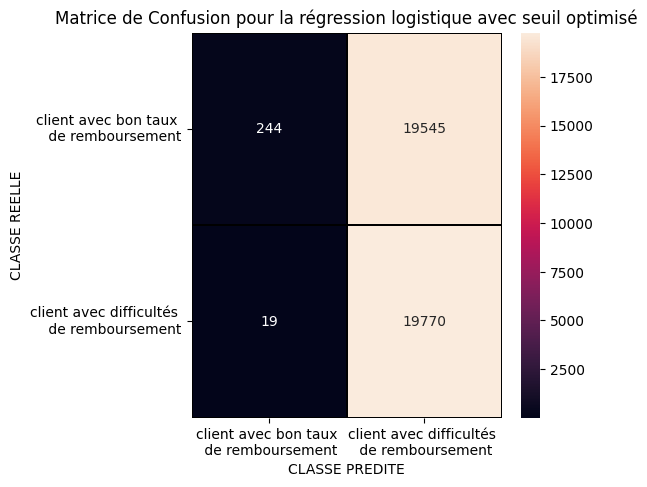

In [39]:
# Graphique de la matrice de confusion
cm_lr = confusion_matrix(y_train_eq, y_lr_opt)

x_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
y_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm_lr, annot=True, linewidths=0.2, linecolor="black",
                fmt=".0f", ax=ax,
                xticklabels=x_axis_labels,
                yticklabels=y_axis_labels)
plt.yticks(rotation=0)
plt.ylabel("CLASSE REELLE")
plt.xlabel("CLASSE PREDITE")
plt.title('Matrice de Confusion pour la régression logistique avec seuil optimisé')
plt.show()

Ici, on voit que les FN ont été minimisés comme nous le souhaitions.

Passons à la prédiction sur les données de test avec le modèle et le seuil de décision optimisés :

In [40]:
# prédiction sur les données de test avec les meilleurs hyperparamètres et le seuil optimisé
y_pred_lr_gd = (best_model_lr_gs.predict_proba(X_test_norm)[:,1] >= seuil_opt_lr).astype(int)
y_prob_lr_gd = best_model_lr_gs.predict_proba(X_test_norm)[:, 1]

In [41]:
# score de la régression logistique avec hyperparamètres et seuil optimisés
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_lr_gd)))
print('Precision Score : ' + str(precision_score(y_test,y_pred_lr_gd)))
print('Recall Score : ' + str(recall_score(y_test,y_pred_lr_gd)))
print('F1 Score : ' + str(f1_score(y_test,y_pred_lr_gd)))
print('F beta Score (avec beta=3) : ' + str(fbeta_score(y_test,y_pred_lr_gd, beta=3)))
print('Aire sous la courbe ROC : ' +str(roc_auc_score(y_test,y_prob_lr_gd)))
print('Aire sous la courbe PR : ' +str(average_precision_score(y_test, y_prob_lr_gd)))

Accuracy Score : 0.09173536250264215
Precision Score : 0.0826421849595165
Recall Score : 0.9992057188244639
F1 Score : 0.1526583238528631
F beta Score (avec beta=3) : 0.47376498168774067
Aire sous la courbe ROC : 0.7477512785448445
Aire sous la courbe PR : 0.22116325763613603


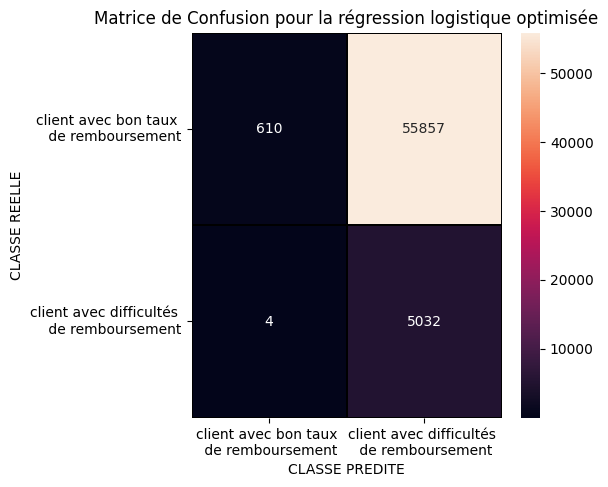

In [42]:
# Graphique de la matrice de confusion
cm_lr = confusion_matrix(y_test, y_pred_lr_gd)

x_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
y_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm_lr, annot=True, linewidths=0.2, linecolor="black",
                fmt=".0f", ax=ax,
                xticklabels=x_axis_labels,
                yticklabels=y_axis_labels)
plt.yticks(rotation=0)
plt.ylabel("CLASSE REELLE")
plt.xlabel("CLASSE PREDITE")
plt.title('Matrice de Confusion pour la régression logistique optimisée')
plt.show()

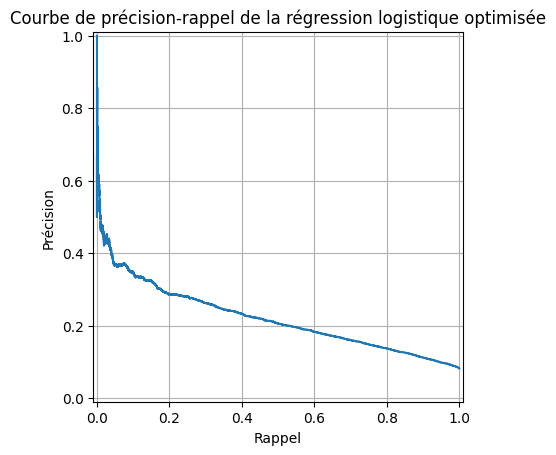

In [43]:
# Graphique précision-rappel
precision_lr, recall_lr, _ = precision_recall_curve(y_test, y_prob_lr_gd)
disp_lr = PrecisionRecallDisplay(precision=precision_lr, recall=recall_lr)
disp_lr.plot()
plt.xlabel('Rappel')
plt.ylabel('Précision')
plt.title('Courbe de précision-rappel de la régression logistique optimisée')
plt.grid(True)
plt.show()

Text(0.5, 1.0, 'Courbe ROC de la régression logistique optimisée')

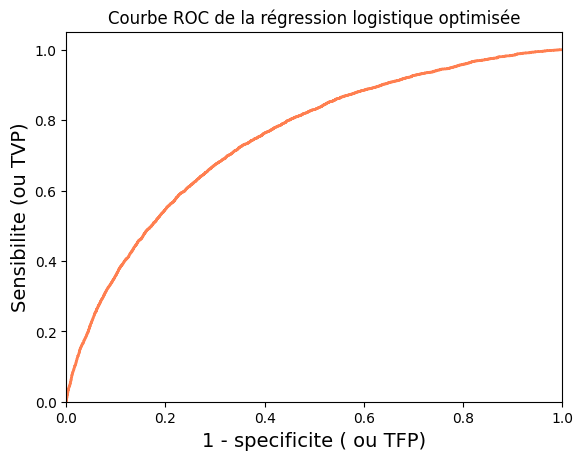

In [44]:
# Graphique courbe ROC
[fpr_lr, tpr_lr, thr_lr] = metrics.roc_curve(y_test, y_prob_lr_gd)
plt.plot(fpr_lr, tpr_lr, color='coral', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - specificite ( ou TFP)', fontsize=14)
plt.ylabel('Sensibilite (ou TVP)', fontsize=14)
plt.title('Courbe ROC de la régression logistique optimisée')

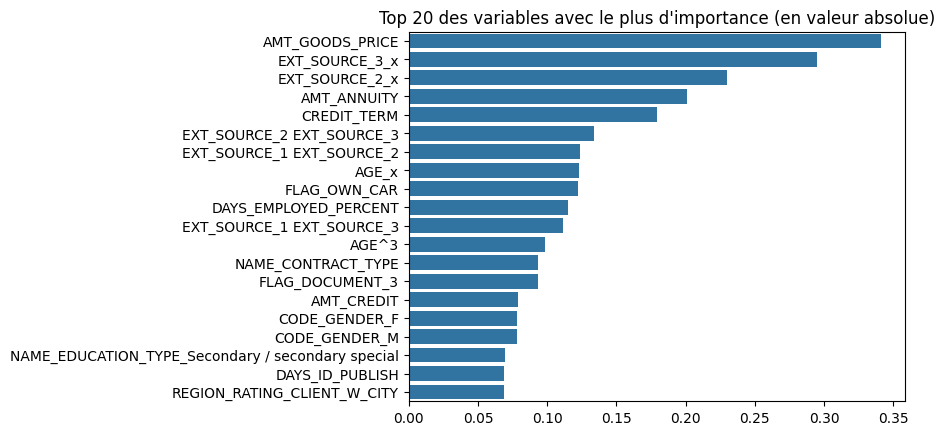

In [45]:
# Graphique des 20 variables qui ont le plus d'importance pour ce modèle optimisé
top_coefficients_lr = (pd.Series(best_model_lr_gs.coef_[0],X_train_eq.columns).map(abs).sort_values(ascending=False).head(20))
sns.barplot(data=top_coefficients_lr, orient="y")
plt.title("Top 20 des variables avec le plus d'importance (en valeur absolue)")
plt.show()

Nous pouvons voir que les données du feature engineering ont une importance élevée dans ce modèle optimisé de régression logistique.

### Modèles linéaires de Machines à Vecteurs de Support (SVM):

Ils ont pour but de séparer linéairement les données en classes à l’aide d’une frontière aussi « simple » que possible, de telle façon que la distance entre les différents groupes de données et la frontière qui les sépare soit maximale. Cette distance est aussi appelée « marge » et les SVMs sont ainsi qualifiés de « séparateurs à vaste marge », les « vecteurs de support » étant les données les plus proches de la frontière.

La version primale résout un problème d'optimisation à p variables et est donc préférable si on a moins de variables que d'échantillons, et inversement pour la version duale.

In [46]:
# Création d'une instance de modèle de SVM de classification
svm = LinearSVC( tol=1e-5,random_state=42)

# On entraîne ce modèle sur les données d'entrainement
svm.fit(X_train_eq,y_train_eq)
y_pred_svm = svm.predict(X_test_norm)



In [47]:
# score de la SVM
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_svm)))
print('Precision Score : ' + str(precision_score(y_test,y_pred_svm)))
print('Recall Score : ' + str(recall_score(y_test,y_pred_svm)))
print('F1 Score : ' + str(f1_score(y_test,y_pred_svm)))
print('F beta Score (avec beta=3) : ' + str(fbeta_score(y_test,y_pred_svm, beta=3)))
print('Aire sous la courbe ROC : ' +str(roc_auc_score(y_test,y_pred_svm)))
print('Aire sous la courbe PR : ' +str(average_precision_score(y_test, y_pred_svm)))

Accuracy Score : 0.6900964180609076
Precision Score : 0.16478630844248973
Recall Score : 0.6844718030182685
F1 Score : 0.2656237959466749
F beta Score (avec beta=3) : 0.5203647232873404
Aire sous la courbe ROC : 0.6875349257179642
Aire sous la courbe PR : 0.13862771972692092


In [48]:
svm = LinearSVC( tol=1e-5,max_iter=200,random_state=42)
params={"C": np.logspace(-5, 5, 10),"penalty":['l1','l2']}

# optimisation des paramètres avec la grid search
grid_svm = GridSearchCV(svm, params,cv=3, n_jobs=-1)
grid_svm.fit(X_train_eq,y_train_eq)

#récupération des meilleurs hyperparamètres
best_model_svm_gs = grid_svm.best_estimator_

In [49]:
print(best_model_svm_gs)

LinearSVC(C=599.4842503189421, max_iter=200, random_state=42, tol=1e-05)


In [50]:
cvres_svm=pd.DataFrame(grid_svm.cv_results_)
cvres_svm

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.542186,0.007675,0.046936,0.002277,0.000010,l1,"{'C': 1e-05, 'penalty': 'l1'}",0.500038,0.499962,0.500000,0.500000,0.000031,20
1,1.706595,0.109692,0.061275,0.007802,0.000010,l2,"{'C': 1e-05, 'penalty': 'l2'}",0.665504,0.665429,0.675788,0.668907,0.004866,18
2,0.684801,0.086675,0.055347,0.003546,0.000129,l1,"{'C': 0.0001291549665014884, 'penalty': 'l1'}",0.643675,0.640491,0.648044,0.644070,0.003096,19
3,4.793753,0.296263,0.089764,0.005038,0.000129,l2,"{'C': 0.0001291549665014884, 'penalty': 'l2'}",0.676419,0.674221,0.687538,0.679393,0.005829,16
4,3.927161,0.095901,0.083356,0.010831,0.001668,l1,"{'C': 0.0016681005372000592, 'penalty': 'l1'}",0.671113,0.672023,0.685036,0.676058,0.006360,17
5,17.000790,0.679777,0.136936,0.011646,0.001668,l2,"{'C': 0.0016681005372000592, 'penalty': 'l2'}",0.678238,0.675737,0.687386,0.680454,0.005007,14
6,15.621361,1.219654,0.119915,0.008792,0.021544,l1,"{'C': 0.021544346900318846, 'penalty': 'l1'}",0.678011,0.676268,0.686931,0.680403,0.004671,15
7,121.691294,90.409035,0.110065,0.001945,0.021544,l2,"{'C': 0.021544346900318846, 'penalty': 'l2'}",0.678466,0.678769,0.688448,0.681894,0.004636,7
8,23.837907,0.714316,0.143940,0.025469,0.278256,l1,"{'C': 0.2782559402207126, 'penalty': 'l1'}",0.678466,0.677405,0.688675,0.681515,0.005081,9
9,474.689446,4.498241,0.053565,0.010166,0.278256,l2,"{'C': 0.2782559402207126, 'penalty': 'l2'}",0.678769,0.678466,0.688751,0.681995,0.004778,6


In [51]:
cols= [i for i in cvres_svm.columns if "split" not in i ]
cvres_svm=cvres_svm [cols].sort_values("rank_test_score")
cvres_svm.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,params,mean_test_score,std_test_score,rank_test_score
19,143.219976,7.307620,0.038562,0.005631,100000.000000,l2,"{'C': 100000.0, 'penalty': 'l2'}",0.682122,0.003888,1
17,180.833729,8.352766,0.090505,0.012371,7742.636827,l2,"{'C': 7742.636826811277, 'penalty': 'l2'}",0.682122,0.003888,1
15,213.705597,19.578591,0.119270,0.004703,599.484250,l2,"{'C': 599.4842503189421, 'penalty': 'l2'}",0.682122,0.003888,1
13,205.469220,6.596113,0.125911,0.011060,46.415888,l2,"{'C': 46.41588833612782, 'penalty': 'l2'}",0.682096,0.003848,4
11,343.686910,49.894711,0.114185,0.002592,3.593814,l2,"{'C': 3.593813663804626, 'penalty': 'l2'}",0.682096,0.003743,5
9,474.689446,4.498241,0.053565,0.010166,0.278256,l2,"{'C': 0.2782559402207126, 'penalty': 'l2'}",0.681995,0.004778,6
7,121.691294,90.409035,0.110065,0.001945,0.021544,l2,"{'C': 0.021544346900318846, 'penalty': 'l2'}",0.681894,0.004636,7
12,24.327116,0.463152,0.122056,0.006312,46.415888,l1,"{'C': 46.41588833612782, 'penalty': 'l1'}",0.681591,0.005025,8
8,23.837907,0.714316,0.143940,0.025469,0.278256,l1,"{'C': 0.2782559402207126, 'penalty': 'l1'}",0.681515,0.005081,9
10,25.729947,1.415553,0.143750,0.003120,3.593814,l1,"{'C': 3.593813663804626, 'penalty': 'l1'}",0.681490,0.005158,10


Les hyperparamètres optimisés correspondent au couple {'C':100000.0, 'penalty': 'l2'} et entrainent une maximisation du mean_test_score égal à 0.682122	.


Maintenant, cherchons à optimiser le seuil de décision de l'algorithme en cherchant à minimiser au maximum le taux de FN, donc en maximisant le recall ou,ici, le f beta score avec beta =3.

In [52]:
# Calcul des probabilité de prédiction
clf = CalibratedClassifierCV(best_model_svm_gs)
clf.fit(X_train_eq,y_train_eq)
y_prob_train_svm_gd = clf.predict_proba(X_train_eq)[:, 1]

In [53]:
# prédiction sur les données d'entrainement avec les meilleurs hyperparamètres
y_pred_train_svm_gd = best_model_svm_gs.predict(X_train_eq)

In [54]:
# F3 score selon les différents seuils de décision
f3_score_svm=[]
for i in [x / 100.0 for x in range(0, 100, 1)]:
  preds=(np.where(y_prob_train_svm_gd > i, 1, 0))
  f3_score_svm.append(str(fbeta_score(y_train_eq,preds, beta=3)))


In [55]:
df=pd.DataFrame(data={'abs': [x / 100.0 for x in range(0, 100, 1)], 'f3_score': f3_score_svm})
df['f3_score']=df['f3_score'].astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   abs       100 non-null    float64
 1   f3_score  100 non-null    float64
dtypes: float64(2)
memory usage: 1.7 KB


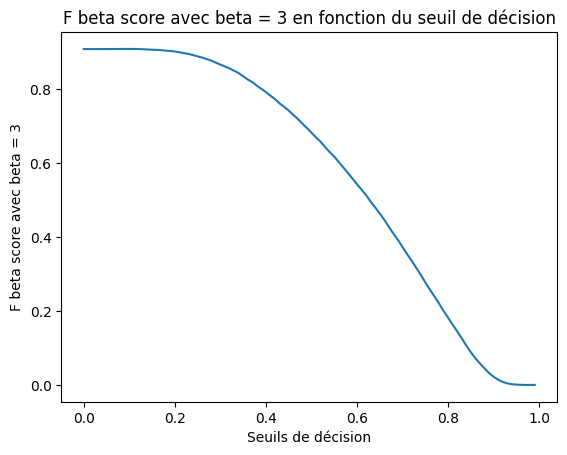

In [56]:
# Affichage des valeurs du F3 score en fonction des différents seuils de décision
plt.plot(df['abs'], df['f3_score'])
plt.title('F beta score avec beta = 3 en fonction du seuil de décision')
plt.xlabel('Seuils de décision')
plt.ylabel('F beta score avec beta = 3')
plt.show()

La solution visuelle n'est pas suffisante pour trouver le bon seuil, cherchons sa valeur numérique.

In [57]:
# Cherchons la valeur maximale du F3 score
f3_score_svm_max=df['f3_score'].max()
# Cherchons la valeur du seuil correspondant au F3 score max
seuil_opt_svm=df.loc[df['f3_score']==f3_score_svm_max,['abs']]
seuil_opt_svm=seuil_opt_svm.values[0,0]
seuil_opt_svm

0.09

In [58]:
# Récupération des prédictions correspondantes au nouveau seuil de décision
y_svm_opt=(y_prob_train_svm_gd> seuil_opt_svm).astype(int)

In [60]:
# score de la régression logistique avec seuil de décision optimisé
print('Accuracy Score : ' + str(accuracy_score(y_train_eq,y_svm_opt)))
print('Precision Score : ' + str(precision_score(y_train_eq,y_svm_opt)))
print('Recall Score : ' + str(recall_score(y_train_eq,y_svm_opt)))
print('F1 Score : ' + str(f1_score(y_train_eq,y_svm_opt)))
print('F beta Score (avec beta=3) : ' + str(fbeta_score(y_train_eq,y_svm_opt, beta=3)))
print('Aire sous la courbe ROC : ' +str(roc_auc_score(y_train_eq,y_svm_opt)))
print('Aire sous la courbe PR : ' +str(average_precision_score(y_train_eq, y_svm_opt)))

Accuracy Score : 0.5070746374248319
Precision Score : 0.5035659704533877
Recall Score : 0.9990398706352014
F1 Score : 0.6696133719453335
F beta Score (avec beta=3) : 0.9095467908226407
Aire sous la courbe ROC : 0.507074637424832
Aire sous la courbe PR : 0.5035625466604414


Nous voyons bien que le F3 score ainsi que le recall ont été maximisé grâce à ce nouveau seuil de 0,09.

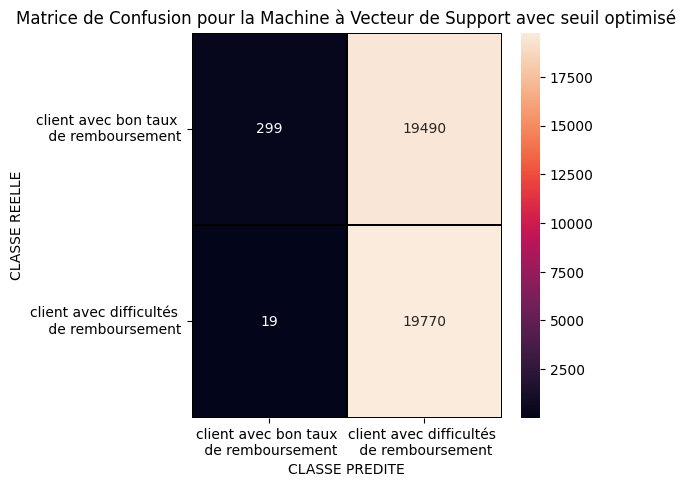

In [61]:
# Graphique de la matrice de confusion
cm_svm = confusion_matrix(y_train_eq, y_svm_opt)

x_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
y_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm_svm, annot=True, linewidths=0.2, linecolor="black",
                fmt=".0f", ax=ax,
                xticklabels=x_axis_labels,
                yticklabels=y_axis_labels)
plt.yticks(rotation=0)
plt.ylabel("CLASSE REELLE")
plt.xlabel("CLASSE PREDITE")
plt.title('Matrice de Confusion pour la Machine à Vecteur de Support avec seuil optimisé')
plt.show()

Ici, on voit que les FN ont été minimisés comme nous le souhaitions.

Passons à la prédiction sur les données de test avec le modèle et le seuil de décision optimisés :

In [62]:
# prédiction sur les données de test avec les meilleurs hyperparamètres et le seuil optimisé
y_pred_svm_gd = (clf.predict_proba(X_test_norm)[:, 1] >= seuil_opt_svm).astype(int)
y_proba_svm_gd =  clf.predict_proba(X_test_norm)[:, 1]

In [63]:
# score de la SVM avec hyperparamètres et seuil optimisés
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_svm_gd)))
print('Precision Score : ' + str(precision_score(y_test,y_pred_svm_gd)))
print('Recall Score : ' + str(recall_score(y_test,y_pred_svm_gd)))
print('F1 Score : ' + str(f1_score(y_test,y_pred_svm_gd)))
print('F beta Score (avec beta=3) : ' + str(fbeta_score(y_test,y_pred_svm_gd, beta=3)))
print('Aire sous la courbe ROC : ' +str(roc_auc_score(y_test,y_pred_svm_gd)))
print('Aire sous la courbe PR : ' +str(average_precision_score(y_test, y_proba_svm_gd)))

Accuracy Score : 0.09544249873989887
Precision Score : 0.08295280328382322
Recall Score : 0.9992057188244639
F1 Score : 0.1531881212231913
F beta Score (avec beta=3) : 0.47478416757088265
Aire sous la courbe ROC : 0.5070231225747871
Aire sous la courbe PR : 0.22432592692586018


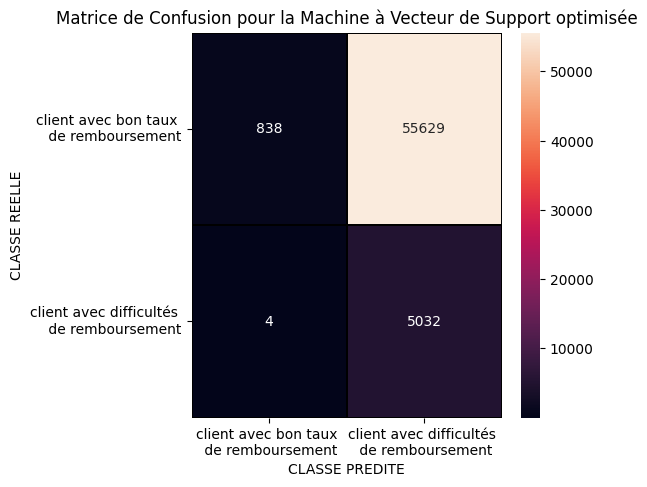

In [64]:
# Graphique de la matrice de confusion
cm_svm = confusion_matrix(y_test, y_pred_svm_gd)

x_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
y_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm_svm, annot=True, linewidths=0.2, linecolor="black",
                fmt=".0f", ax=ax,
                xticklabels=x_axis_labels,
                yticklabels=y_axis_labels)
plt.yticks(rotation=0)
plt.ylabel("CLASSE REELLE")
plt.xlabel("CLASSE PREDITE")
plt.title('Matrice de Confusion pour la Machine à Vecteur de Support optimisée')
plt.show()

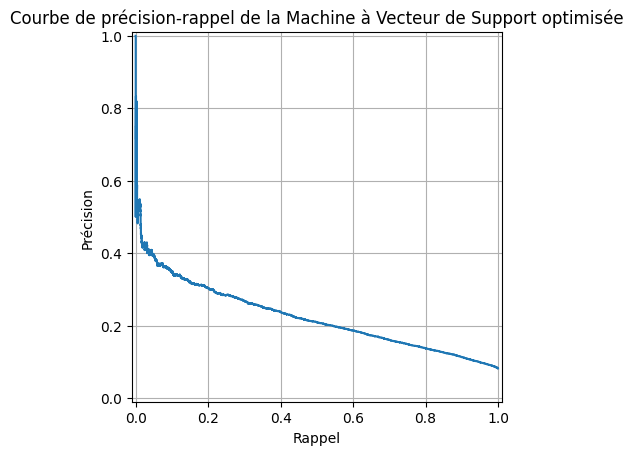

In [65]:
# Graphique précision-rappel
precision_svm, recall_svm, _ = precision_recall_curve(y_test, y_proba_svm_gd)
disp_svm = PrecisionRecallDisplay(precision=precision_svm, recall=recall_svm)
disp_svm.plot()
plt.xlabel('Rappel')
plt.ylabel('Précision')
plt.title('Courbe de précision-rappel de la Machine à Vecteur de Support optimisée')
plt.grid(True)
plt.show()

Text(0.5, 1.0, 'Courbe ROC de la Machine à Vecteur de Support optimisée')

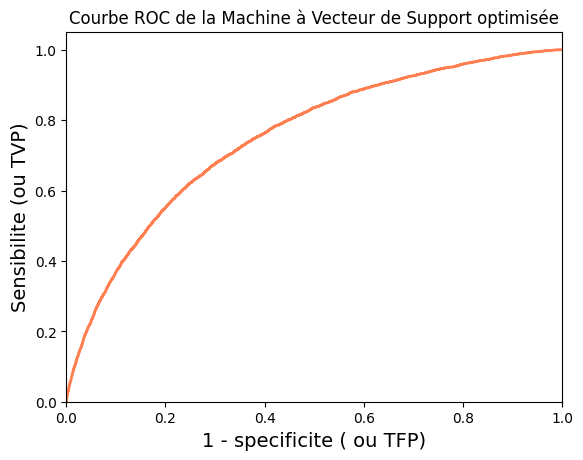

In [66]:
# Graphique courbe ROC
[fpr_svm, tpr_svm, thr_svm] = metrics.roc_curve(y_test, y_proba_svm_gd)
plt.plot(fpr_svm, tpr_svm, color='coral', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - specificite ( ou TFP)', fontsize=14)
plt.ylabel('Sensibilite (ou TVP)', fontsize=14)
plt.title('Courbe ROC de la Machine à Vecteur de Support optimisée')

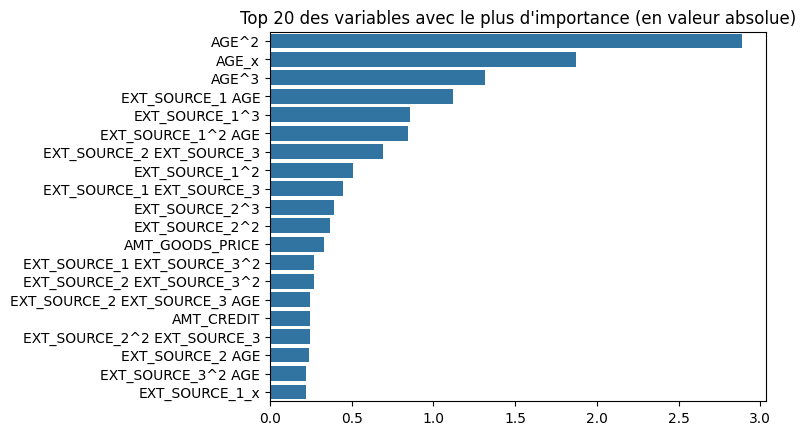

In [67]:
# Graphique des 20 variables qui ont le plus d'importance pour ce modèle optimisé
top_coefficients_svm = (pd.Series(best_model_svm_gs.coef_[0],X_train_eq.columns).map(abs).sort_values(ascending=False).head(20))
sns.barplot(data=top_coefficients_svm, orient="y")
plt.title("Top 20 des variables avec le plus d'importance (en valeur absolue)")
plt.show()

Nous pouvons voir que les données liées à l'âge et aux EXT_SOURCE ont une importance élevée dans ce modèle optimisé de SVM.



### Modèles non-linéaires de SVM à noyau:

 Afin de remédier au problème de l'absence de séparateur linéaire, on utilise un noyau (en anglais kernel) pour déplacer le problème dans un espace de dimension supérieure, éventuellement de dimension infinie.

 Dans ce nouvel espace, appelé espace de redescription, il est alors probable qu'il existe une séparation linéaire.

La fonction noyau choisie doit respecter certaines conditions : être symétrique et semi-définie positive. Cela peut être une fonction noyau polynômial ou exponentielle, ou gaussien(RBF),...

In [68]:
# Création d'une instance de modèle de SVM de classification à noyau
svm_noy = SVC(tol=1e-5,max_iter=200,random_state=42)

# On entraîne ce modèle sur les données d'entrainement
svm_noy.fit(X_train_eq,y_train_eq)
y_pred_svm_noy = svm_noy.predict(X_test_norm)

In [69]:
# score de la SVM à noyau
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_svm_noy)))
print('Precision Score : ' + str(precision_score(y_test,y_pred_svm_noy)))
print('Recall Score : ' + str(recall_score(y_test,y_pred_svm_noy)))
print('F1 Score : ' + str(f1_score(y_test,y_pred_svm_noy)))
print('F beta Score (avec beta=3) : ' + str(fbeta_score(y_test,y_pred_svm_noy, beta=3)))
print('Aire sous la courbe ROC : ' +str(roc_auc_score(y_test,y_pred_svm_noy)))
print('Aire sous la courbe PR : ' +str(average_precision_score(y_test, y_pred_svm_noy)))

Accuracy Score : 0.6354649366697559
Precision Score : 0.10683915324769314
Recall Score : 0.4690230341540905
F1 Score : 0.17403477748305335
F beta Score (avec beta=3) : 0.3502787993830822
Aire sous la courbe ROC : 0.559666032103521
Aire sous la courbe PR : 0.09358757776314508


In [75]:
svm_noy = SVC( tol=1e-5,max_iter=200,random_state=42,probability=True)
params={"C": np.logspace(-5, 5, 10),"kernel":['poly', 'rbf', 'sigmoid'],"gamma": ["scale", "auto"]}

# optimisation des paramètres avec la grid search
grid_svm_noy = GridSearchCV(svm_noy, params,cv=3)
grid_svm_noy.fit(X_train_eq,y_train_eq)

#récupération des meilleurs hyperparamètres
best_model_svm_noy_gs = grid_svm_noy.best_estimator_

In [76]:
print(best_model_svm_noy_gs)

SVC(C=0.2782559402207126, gamma='auto', max_iter=200, probability=True,
    random_state=42, tol=1e-05)


In [77]:
print(grid_svm_noy.best_params_)

{'C': 0.2782559402207126, 'gamma': 'auto', 'kernel': 'rbf'}


In [78]:
cvres_svm_noy=pd.DataFrame(grid_svm_noy.cv_results_)
cvres_svm_noy

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,13.378545,0.047257,0.198938,0.000385,0.000010,scale,poly,"{'C': 1e-05, 'gamma': 'scale', 'kernel': 'poly'}",0.499962,0.500114,0.500152,0.500076,0.000082,50
1,15.227707,0.110858,0.916273,0.023541,0.000010,scale,rbf,"{'C': 1e-05, 'gamma': 'scale', 'kernel': 'rbf'}",0.563177,0.557341,0.600440,0.573653,0.019091,6
2,13.894156,0.102375,0.244350,0.007860,0.000010,scale,sigmoid,"{'C': 1e-05, 'gamma': 'scale', 'kernel': 'sigm...",0.527098,0.496021,0.525849,0.516322,0.014365,33
3,13.416904,0.154172,0.199561,0.012898,0.000010,auto,poly,"{'C': 1e-05, 'gamma': 'auto', 'kernel': 'poly'}",0.499962,0.500114,0.500152,0.500076,0.000082,50
4,15.121954,0.142929,0.906823,0.049796,0.000010,auto,rbf,"{'C': 1e-05, 'gamma': 'auto', 'kernel': 'rbf'}",0.560221,0.595770,0.552380,0.569457,0.018880,9
5,13.890935,0.026826,0.247079,0.012508,0.000010,auto,sigmoid,"{'C': 1e-05, 'gamma': 'auto', 'kernel': 'sigmo...",0.528007,0.508755,0.523272,0.520011,0.008191,29
6,12.657974,0.369587,0.199396,0.000479,0.000129,scale,poly,"{'C': 0.0001291549665014884, 'gamma': 'scale',...",0.499962,0.500038,0.500076,0.500025,0.000047,53
7,15.000787,0.058375,0.876587,0.074706,0.000129,scale,rbf,"{'C': 0.0001291549665014884, 'gamma': 'scale',...",0.563177,0.557341,0.600440,0.573653,0.019091,6
8,13.844103,0.031503,0.233327,0.000156,0.000129,scale,sigmoid,"{'C': 0.0001291549665014884, 'gamma': 'scale',...",0.527098,0.496021,0.525849,0.516322,0.014365,33
9,13.083512,0.059274,0.199776,0.000082,0.000129,auto,poly,"{'C': 0.0001291549665014884, 'gamma': 'auto', ...",0.499962,0.500038,0.500152,0.500051,0.000078,52


In [79]:
cols= [i for i in cvres_svm_noy.columns if "split" not in i ]
cvres_svm_noy=cvres_svm_noy [cols].sort_values("rank_test_score")
cvres_svm_noy.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,mean_test_score,std_test_score,rank_test_score
28,14.716560,0.135872,0.899726,0.013715,0.278256,auto,rbf,"{'C': 0.2782559402207126, 'gamma': 'auto', 'ke...",0.588938,0.002288,1
22,15.260764,0.911822,0.871654,0.069203,0.021544,auto,rbf,"{'C': 0.021544346900318846, 'gamma': 'auto', '...",0.584138,0.007195,2
16,14.849885,0.129428,0.927823,0.050724,0.001668,auto,rbf,"{'C': 0.0016681005372000592, 'gamma': 'auto', ...",0.580954,0.015104,3
19,14.649838,0.071952,0.849753,0.040759,0.021544,scale,rbf,"{'C': 0.021544346900318846, 'gamma': 'scale', ...",0.574941,0.004201,4
53,13.260930,0.177538,0.238723,0.015581,7742.636827,auto,sigmoid,"{'C': 7742.636826811277, 'gamma': 'auto', 'ker...",0.574461,0.009563,5
1,15.227707,0.110858,0.916273,0.023541,0.000010,scale,rbf,"{'C': 1e-05, 'gamma': 'scale', 'kernel': 'rbf'}",0.573653,0.019091,6
7,15.000787,0.058375,0.876587,0.074706,0.000129,scale,rbf,"{'C': 0.0001291549665014884, 'gamma': 'scale',...",0.573653,0.019091,6
13,15.214115,0.128827,0.870963,0.021670,0.001668,scale,rbf,"{'C': 0.0016681005372000592, 'gamma': 'scale',...",0.573653,0.019091,6
4,15.121954,0.142929,0.906823,0.049796,0.000010,auto,rbf,"{'C': 1e-05, 'gamma': 'auto', 'kernel': 'rbf'}",0.569457,0.018880,9
10,14.640315,0.280320,0.842959,0.052296,0.000129,auto,rbf,"{'C': 0.0001291549665014884, 'gamma': 'auto', ...",0.569457,0.018880,9


Les hyperparamètres optimisés correspondent aux paramètres {'C': 0.278256, 'gamma': 'auto', 'kernel': 'rbf'} et entrainent une maximisation du mean_test_score égal à 0.588938.


Maintenant, cherchons à optimiser le seuil de décision de l'algorithme en cherchant à minimiser au maximum le taux de FN, donc en maximisant le recall ou,ici, le f beta score avec beta =3.

In [80]:
# prédiction sur les données d'entrainement avec les meilleurs hyperparamètres
y_prob_train_svm_noy_gd = best_model_svm_noy_gs.predict_proba(X_train_eq)[:, 1]
y_pred_train_svm_noy_gd = best_model_svm_noy_gs.predict(X_train_eq)

In [81]:
# F3 score selon les différents seuils de décision
f3_score_svm_noy=[]
for i in [x / 100.0 for x in range(0, 100, 1)]:
  preds=(np.where(y_prob_train_svm_noy_gd > i, 1, 0))
  f3_score_svm_noy.append(str(fbeta_score(y_train_eq,preds, beta=3)))

In [82]:
df=pd.DataFrame(data={'abs': [x / 100.0 for x in range(0, 100, 1)], 'f3_score': f3_score_svm_noy})
df['f3_score']=df['f3_score'].astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   abs       100 non-null    float64
 1   f3_score  100 non-null    float64
dtypes: float64(2)
memory usage: 1.7 KB


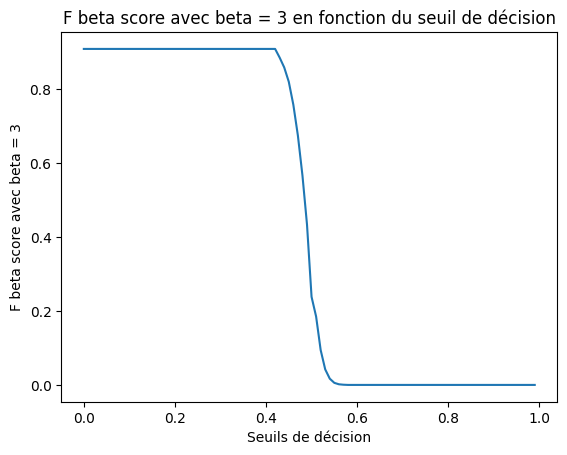

In [83]:
# Affichage des valeurs du F3 score en fonction des différents seuils de décision
plt.plot(df['abs'], df['f3_score'])
plt.title('F beta score avec beta = 3 en fonction du seuil de décision')
plt.xlabel('Seuils de décision')
plt.ylabel('F beta score avec beta = 3')
plt.show()

La solution visuelle n'est pas suffisante pour trouver le bon seuil, cherchons sa valeur numérique.

In [84]:
# Cherchons la valeur maximale du F3 score
f3_score_svm_noy_max=df['f3_score'].max()
# Cherchons la valeur du seuil correspondant au F3 score max
seuil_opt_svm_noy=df.loc[df['f3_score']==f3_score_svm_noy_max,['abs']]
seuil_opt_svm_noy=seuil_opt_svm_noy.values[0,0]
seuil_opt_svm_noy

0.42

In [85]:
# Récupération des prédictions correspondantes au nouveau seuil de décision
y_svm_noy_opt=(y_prob_train_svm_noy_gd> seuil_opt_svm_noy).astype(int)

In [86]:
# score de la SVM à noyau avec seuil de décision optimisé
print('Accuracy Score : ' + str(accuracy_score(y_train_eq,y_svm_noy_opt)))
print('Precision Score : ' + str(precision_score(y_train_eq,y_svm_noy_opt)))
print('Recall Score : ' + str(recall_score(y_train_eq,y_svm_noy_opt)))
print('F1 Score : ' + str(f1_score(y_train_eq,y_svm_noy_opt)))
print('F beta Score (avec beta=3) : ' + str(fbeta_score(y_train_eq,y_svm_noy_opt, beta=3)))
print('Aire sous la courbe ROC : ' +str(roc_auc_score(y_train_eq,y_svm_noy_opt)))
print('Aire sous la courbe PR : ' +str(average_precision_score(y_train_eq, y_svm_noy_opt)))

Accuracy Score : 0.5000505331244631
Precision Score : 0.5000252678390944
Recall Score : 1.0
F1 Score : 0.6666891265897414
F beta Score (avec beta=3) : 0.9090992617502078
Aire sous la courbe ROC : 0.5000505331244631
Aire sous la courbe PR : 0.5000252678390944


Nous voyons bien que le F3 score ainsi que le recall ont été maximisé grâce à ce nouveau seuil de 0,42.

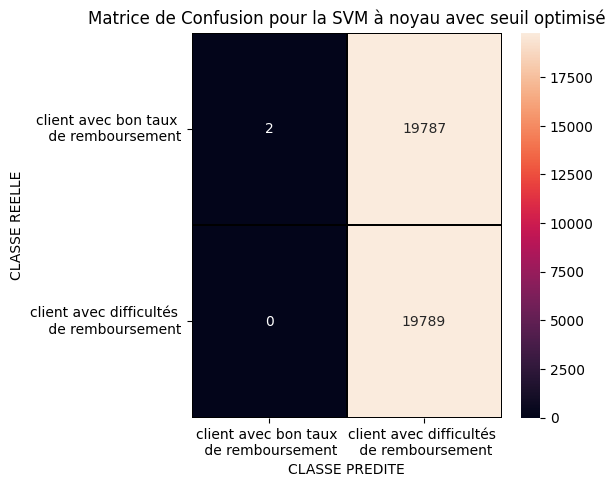

In [87]:
# Graphique de la matrice de confusion
cm_svm_noy = confusion_matrix(y_train_eq, y_svm_noy_opt)

x_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
y_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm_svm_noy, annot=True, linewidths=0.2, linecolor="black",
                fmt=".0f", ax=ax,
                xticklabels=x_axis_labels,
                yticklabels=y_axis_labels)
plt.yticks(rotation=0)
plt.ylabel("CLASSE REELLE")
plt.xlabel("CLASSE PREDITE")
plt.title('Matrice de Confusion pour la SVM à noyau avec seuil optimisé')
plt.show()

Ici, on voit que les FN ont été minimisés comme nous le souhaitions mais il n'y a quasiment plus aucune prédiction de client avec un bon  taux de remboursement, ce qui n'est pas pertinent.

Passons à la prédiction sur les données de test avec le modèle et le seuil de décision optimisés :

In [88]:
# prédiction sur les données de test avec les meilleurs hyperparamètres et le seuil optimisé
y_pred_svm_noy_gd = (best_model_svm_noy_gs.predict_proba(X_test_norm)[:, 1] >= seuil_opt_svm_noy).astype(int)
y_prob_svm_noy_gd = best_model_svm_noy_gs.predict_proba(X_test_norm)[:, 1]

In [89]:
# score de la SVM à noyau avec hyperparamètres optimisés
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_svm_noy_gd)))
print('Precision Score : ' + str(precision_score(y_test,y_pred_svm_noy_gd)))
print('Recall Score : ' + str(recall_score(y_test,y_pred_svm_noy_gd)))
print('F1 Score : ' + str(f1_score(y_test,y_pred_svm_noy_gd)))
print('F beta Score (avec beta=3) : ' + str(fbeta_score(y_test,y_pred_svm_noy_gd, beta=3)))
print('Aire sous la courbe ROC : ' +str(roc_auc_score(y_test,y_prob_svm_noy_gd)))
print('Aire sous la courbe PR : ' +str(average_precision_score(y_test, y_prob_svm_noy_gd)))

Accuracy Score : 0.08188218460888087
Precision Score : 0.08188218460888087
Recall Score : 1.0
F1 Score : 0.15136987330738363
F beta Score (avec beta=3) : 0.4714164022204124
Aire sous la courbe ROC : 0.5773613347631623
Aire sous la courbe PR : 0.10691381301918007


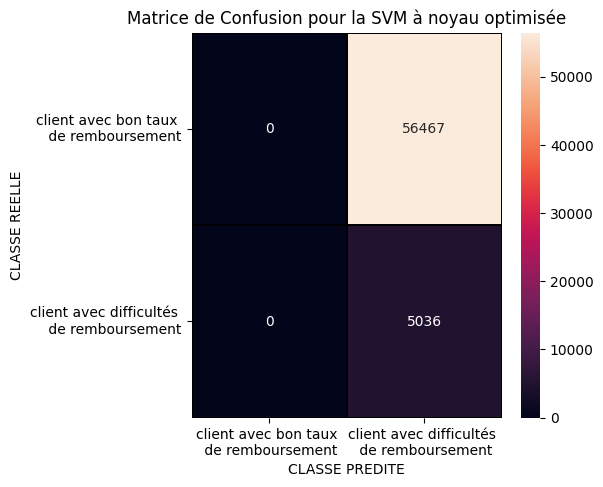

In [90]:
# Graphique de la matrice de confusion
cm_svm = confusion_matrix(y_test, y_pred_svm_noy_gd)

x_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
y_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm_svm, annot=True, linewidths=0.2, linecolor="black",
                fmt=".0f", ax=ax,
                xticklabels=x_axis_labels,
                yticklabels=y_axis_labels)
plt.yticks(rotation=0)
plt.ylabel("CLASSE REELLE")
plt.xlabel("CLASSE PREDITE")
plt.title('Matrice de Confusion pour la SVM à noyau optimisée')
plt.show()

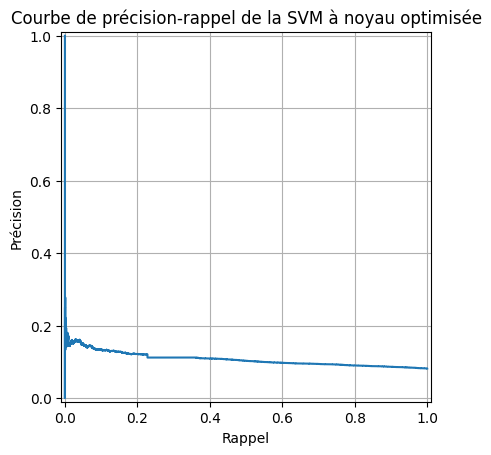

In [91]:
# Graphique précision-rappel
precision_svm_noy, recall_svm_noy, _ = precision_recall_curve(y_test, y_prob_svm_noy_gd)
disp_svm_noy = PrecisionRecallDisplay(precision=precision_svm_noy, recall=recall_svm_noy)
disp_svm_noy.plot()
plt.xlabel('Rappel')
plt.ylabel('Précision')
plt.title('Courbe de précision-rappel de la SVM à noyau optimisée')
plt.grid(True)
plt.show()

Text(0.5, 1.0, 'Courbe ROC de la SVM à noyau optimisée')

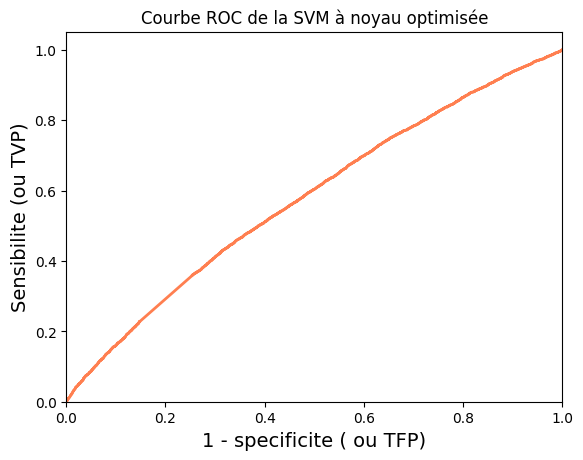

In [92]:
# Graphique courbe ROC
[fpr_svm_noy, tpr_svm_noy, thr_svm_noy] = metrics.roc_curve(y_test, y_prob_svm_noy_gd)
plt.plot(fpr_svm_noy, tpr_svm_noy, color='coral', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - specificite ( ou TFP)', fontsize=14)
plt.ylabel('Sensibilite (ou TVP)', fontsize=14)
plt.title('Courbe ROC de la SVM à noyau optimisée')

Text(0.5, 0, "Top 20 des variables avec le plus d'importance")

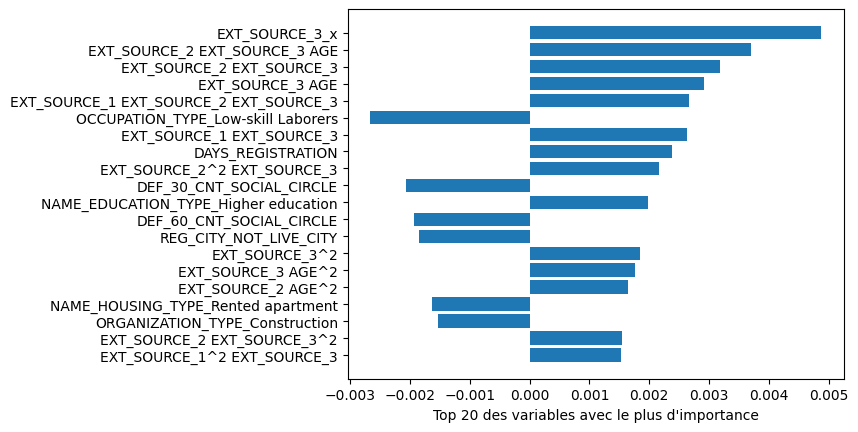

In [93]:
# Graphique des 20 variables qui ont le plus d'importance pour ce modèle optimisé
perm_importance = permutation_importance(best_model_svm_noy_gs, X_train_eq,y_train_eq)

feature_names = X_train_eq.columns
features = np.array(feature_names)

sorted_idx = abs(perm_importance.importances_mean).argsort()
plt.barh(features[sorted_idx[-20:]], perm_importance.importances_mean[sorted_idx[-20:]])
plt.xlabel("Top 20 des variables avec le plus d'importance")


Nous pouvons voir que les données liées à l'âge et aux EXT_SOURCE ont une importance élevéedans ce modèle optimisé de SVM à noyau RBF.

### Modèles de réseaux de neurones:


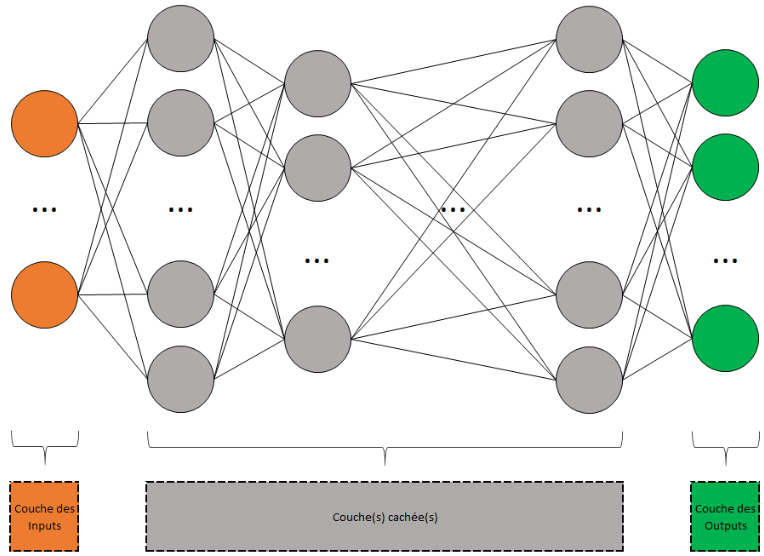

Dans un réseau, le neurone est une unité qui reçoit l'information, procède à des calculs simples, et la transmet à une autre unité. On distingue trois types de neurones dans un réseau artificiel :
- Les neurones d'entrées qui reçoivent les données du monde extérieur (couche d'entrée) ;
- Les neurones de traitement (couche cachée) ;
- Les neurones de sorties (couche de sortie).

Il permet d'apprendre des modèles de régression (la fonction d'activation est l'identité), de classification binaire (la fonction d'activation est la fonction logistique) ou de classification multi-classe (la fonction d'activation est la fonction softmax).

Chaque connexion a un poids spécifique qui influence la transmission de l'information d'une unité à une autre. Les informations provenant d'une connexion avec un poids important seront ainsi dominantes à l'entrée du neurone suivant, comparativement à celles provenant de connexions à poids faible. Ces dernières ne sont cependant pas ignorées lors du traitement de l'information. Les poids sont mis à jour de façon itérative grâce à l'algorithme du gradient.

L'entraînement de ces réseaux se fait par rétro-propagation. Attention, cet algorithme ne converge pas nécessairement, et pas nécessairement vers la solution optimale ! Plus il y a de paramètres, plus il faut de données pour pouvoir apprendre les valeurs de ces paramètres sans risquer le sur-apprentissage.

In [94]:
#Création d'une instance de réseau de neurones.

#Nous utilisons la fonction Sequential() qui est approprié pour notre problème(cf bibliothèque Keras: https://keras.io/guides/sequential_model/)
neuron= tf.keras.Sequential()
#On indique à notre modèle la dimension des données d'entrées qui correspond au nombre de colonnes de X_train, c'est à dire 276.
neuron.add(tf.keras.layers.InputLayer(input_shape=[276]))
#Première couche de notre réseau de neurones avec 276 perceptrons.
#La fonction sigmoide est particulièrement indiqué pour les problèmes de classification.
neuron.add(tf.keras.layers.Dense(276, input_dim=2, activation='sigmoid'))
#Seconde couche car nous sommes dans un problème non linéaire
neuron.add(tf.keras.layers.Dense(1, activation='sigmoid'))

#Ici, nous pouvons ajouter des paramètres à notre modèle. Il faut juste retenir que "accuracy" permet d'avoir
#la précision de notre modèle et est particulièrement indiqué pour les problèmes de classification.

neuron.compile(metrics=[tf.keras.metrics.Accuracy(name='my_accuracy'), tf.keras.metrics.Precision(name='my_precision'),tf.keras.metrics.Recall(name='my_recall'),tf.keras.metrics.F1Score( name="my_f1_score"),tf.keras.metrics.FBetaScore( beta=3.0, name="my_fbeta_score"),tf.keras.metrics.AUC(curve='ROC',name='my_aucroc'),tf.keras.metrics.AUC(curve='PR',name='my_aucpr')],
                  loss="binary_crossentropy",
                  optimizer="adam")

In [95]:
#"summary" permet d'avoir les paramètres qui la compose ainsi que les dimensions à la sortie de chaque couche
neuron.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 276)                 │          76,452 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             277 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 76,729 (299.72 KB)

 Trainable params: 76,729 (299.72 KB)

 Non-trainable params: 0 (0.00 B)

In [96]:
# On entraine le modèle de réseau de neurone
history = neuron.fit(X_train_eq,
                    y_train_eq,
                    epochs = 50,
                    batch_size = 200,
                    verbose = 1)

Epoch 1/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6179 - my_accuracy: 0.0000e+00 - my_aucpr: 0.7019 - my_aucroc: 0.7193 - my_f1_score: 0.6653 - my_fbeta_score: 0.9086 - my_precision: 0.6430 - my_recall: 0.7130
Epoch 2/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5970 - my_accuracy: 0.0000e+00 - my_aucpr: 0.7348 - my_aucroc: 0.7444 - my_f1_score: 0.6695 - my_fbeta_score: 0.9101 - my_precision: 0.6768 - my_recall: 0.6899
Epoch 3/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5939 - my_accuracy: 0.0000e+00 - my_aucpr: 0.7345 - my_aucroc: 0.7480 - my_f1_score: 0.6653 - my_fbeta_score: 0.9086 - my_precision: 0.6758 - my_recall: 0.6887
Epoch 4/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5932 - my_accuracy: 0.0000e+00 - my_aucpr: 0.7396 - my_aucroc: 0.7477 - my_f1_score: 0.6688 - my_fbeta_score: 0.9099 - my_precision: 0.6818 - my_recall: 0.6846
Epoch 5/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5901 - my_accuracy: 0.0000e+00 - my_aucpr: 0.7402 

In [97]:
y_pred_neuron = neuron.predict(X_test_norm)

1922/1922 ━━━━━━━━━━━━━━━━━━━━ 1s 520us/step


In [98]:
#On évalue notre modèle
result = neuron.evaluate(X_test_norm, y_test, verbose=1)

print('Accuracy Score : ' + str(result[1]))
print('Precision Score : ' + str(result[2]))
print('Recall Score : ' + str(result[3]))
print('F1 Score : ' + str(result[4]))
print('F beta Score (avec beta=3) : ' + str(result[5]))
print('Aire sous la courbe ROC : ' +str(result[6]))
print('Aire sous la courbe PR : ' +str(result[7]))

1922/1922 ━━━━━━━━━━━━━━━━━━━━ 2s 646us/step - loss: 0.8448 - my_accuracy: 0.0000e+00 - my_aucpr: 0.1555 - my_aucroc: 0.6925 - my_f1_score: 0.1472 - my_fbeta_score: 0.4629 - my_precision: 0.1290 - my_recall: 0.6672
Accuracy Score : 0.0
Precision Score : 0.13151364028453827
Recall Score : 0.6630262136459351
F1 Score : 0.1513812392950058
F beta Score (avec beta=3) : 0.4714384377002716
Aire sous la courbe ROC : 0.6900383830070496
Aire sous la courbe PR : 0.16665536165237427


In [99]:
# optimisation des paramètres avec la grid search
batch_size = [50,100, 100,150,200]
epochs = [10, 50, 100]
param_grid = dict(batch_size=batch_size, epochs=epochs)
model = KerasClassifier(model=neuron, verbose=0)

grid_neuron = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_neuron.fit(X_train_eq,y_train_eq)
#récupération des meilleurs hyperparamètres
best_model_neuron_gs = grid_neuron.best_estimator_

In [100]:
print(best_model_neuron_gs)

KerasClassifier(
	model=<Sequential name=sequential, built=True>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=200
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=10
	class_weight=None
)


In [101]:
cvres_neuron=pd.DataFrame(grid_neuron.cv_results_)
cvres_neuron

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_batch_size,param_epochs,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,22.532760,1.422818,1.891709,0.059542,50,10,"{'batch_size': 50, 'epochs': 10}",0.835974,0.834382,0.833914,0.834757,0.000881,5
1,133.114221,1.261259,1.736284,0.155595,50,50,"{'batch_size': 50, 'epochs': 50}",0.753960,0.755855,0.752198,0.754005,0.001493,11
2,272.517815,6.332791,2.739582,0.596506,50,100,"{'batch_size': 50, 'epochs': 100}",0.738422,0.735314,0.734233,0.735990,0.001776,15
3,26.563581,0.915971,1.370242,0.149427,100,10,"{'batch_size': 100, 'epochs': 10}",0.858940,0.859926,0.858323,0.859063,0.000660,4
4,99.927342,4.477799,1.976464,0.731664,100,50,"{'batch_size': 100, 'epochs': 50}",0.771773,0.767301,0.767207,0.768760,0.002131,9
5,174.445335,4.725973,1.631642,0.202405,100,100,"{'batch_size': 100, 'epochs': 100}",0.741530,0.741530,0.740525,0.741195,0.000474,14
6,27.279313,2.395142,1.527957,0.255621,100,10,"{'batch_size': 100, 'epochs': 10}",0.860987,0.859244,0.857717,0.859316,0.001336,3
7,92.226062,0.779288,1.335185,0.424758,100,50,"{'batch_size': 100, 'epochs': 50}",0.769272,0.767604,0.769482,0.768786,0.000840,8
8,172.784106,6.906122,1.230981,0.116197,100,100,"{'batch_size': 100, 'epochs': 100}",0.741984,0.745850,0.741283,0.743039,0.002008,13
9,23.821847,2.503475,1.032962,0.060921,150,10,"{'batch_size': 150, 'epochs': 10}",0.874024,0.868567,0.874166,0.872252,0.002607,2


In [102]:
cols= [i for i in cvres_neuron.columns if "split" not in i ]
cvres_neuron=cvres_neuron [cols].sort_values("rank_test_score")
cvres_neuron.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_batch_size,param_epochs,params,mean_test_score,std_test_score,rank_test_score
12,22.942275,2.435452,1.014410,0.050944,200,10,"{'batch_size': 200, 'epochs': 10}",0.882612,0.002050,1
9,23.821847,2.503475,1.032962,0.060921,150,10,"{'batch_size': 150, 'epochs': 10}",0.872252,0.002607,2
6,27.279313,2.395142,1.527957,0.255621,100,10,"{'batch_size': 100, 'epochs': 10}",0.859316,0.001336,3
3,26.563581,0.915971,1.370242,0.149427,100,10,"{'batch_size': 100, 'epochs': 10}",0.859063,0.000660,4
0,22.532760,1.422818,1.891709,0.059542,50,10,"{'batch_size': 50, 'epochs': 10}",0.834757,0.000881,5
13,52.161382,0.949245,0.760901,0.200326,200,50,"{'batch_size': 200, 'epochs': 50}",0.792461,0.002047,6
10,65.402708,0.347725,1.134553,0.058766,150,50,"{'batch_size': 150, 'epochs': 50}",0.782910,0.001348,7
7,92.226062,0.779288,1.335185,0.424758,100,50,"{'batch_size': 100, 'epochs': 50}",0.768786,0.000840,8
4,99.927342,4.477799,1.976464,0.731664,100,50,"{'batch_size': 100, 'epochs': 50}",0.768760,0.002131,9
14,64.177591,1.522650,0.214550,0.025552,200,100,"{'batch_size': 200, 'epochs': 100}",0.757390,0.000905,10


Les hyperparamètres optimisés correspondent au couple {'batch_size': 200, 'epochs': 10} et entrainent une maximisation du mean_test_score égal à 0.882612.


Maintenant, cherchons à optimiser le seuil de décision de l'algorithme en cherchant à minimiser au maximum le taux de FN, donc en maximisant le recall ou,ici, le f beta score avec beta =3.

In [103]:
# prédiction sur les données d'entrainement avec les meilleurs hyperparamètres
y_prob_train_neuron_gd = best_model_neuron_gs.predict_proba(X_train_eq)[:, 1]
y_pred_train_neuron_gd = best_model_neuron_gs.predict(X_train_eq)

In [104]:
# F3 score selon les différents seuils de décision
f3_score_neuron=[]
for i in [x / 100.0 for x in range(0, 100, 1)]:
  preds=(np.where(y_prob_train_neuron_gd > i, 1, 0))
  f3_score_neuron.append(str(fbeta_score(y_train_eq,preds, beta=3)))

In [105]:
df=pd.DataFrame(data={'abs': [x / 100.0 for x in range(0, 100, 1)], 'f3_score': f3_score_neuron})
df['f3_score']=df['f3_score'].astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   abs       100 non-null    float64
 1   f3_score  100 non-null    float64
dtypes: float64(2)
memory usage: 1.7 KB


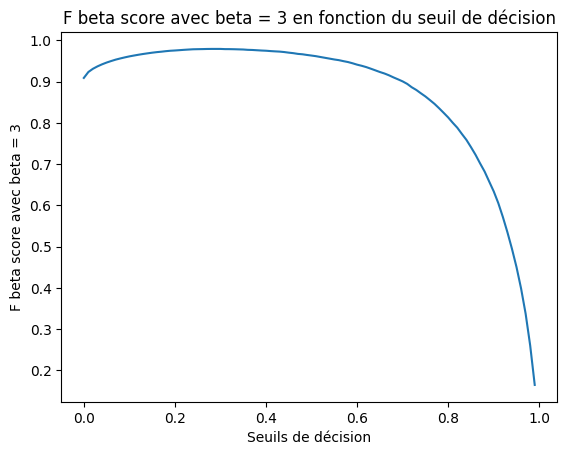

In [106]:
# Affichage des valeurs du F3 score en fonction des différents seuils de décision
plt.plot(df['abs'], df['f3_score'])
plt.title('F beta score avec beta = 3 en fonction du seuil de décision')
plt.xlabel('Seuils de décision')
plt.ylabel('F beta score avec beta = 3')
plt.show()

La solution visuelle n'est pas suffisante pour trouver le bon seuil, cherchons sa valeur numérique.

In [107]:
# Cherchons la valeur maximale du F3 score
f3_score_neuron_max=df['f3_score'].max()
# Cherchons la valeur du seuil correspondant au F3 score max
seuil_opt_neuron=df.loc[df['f3_score']==f3_score_neuron_max,['abs']]
seuil_opt_neuron=seuil_opt_neuron.values[0,0]
seuil_opt_neuron

0.29

In [108]:
# Récupération des prédictions correspondantes au nouveau seuil de décision
y_neuron_opt=(y_prob_train_neuron_gd> seuil_opt_neuron).astype(int)

In [109]:
# score du réseau de neurone avec seuil de décision optimisé
print('Accuracy Score : ' + str(accuracy_score(y_train_eq,y_neuron_opt)))
print('Precision Score : ' + str(precision_score(y_train_eq,y_neuron_opt)))
print('Recall Score : ' + str(recall_score(y_train_eq,y_neuron_opt)))
print('F1 Score : ' + str(f1_score(y_train_eq,y_neuron_opt)))
print('F beta Score (avec beta=3) : ' + str(fbeta_score(y_train_eq,y_neuron_opt, beta=3)))
print('Aire sous la courbe ROC : ' +str(roc_auc_score(y_train_eq,y_neuron_opt)))
print('Aire sous la courbe PR : ' +str(average_precision_score(y_train_eq, y_neuron_opt)))

Accuracy Score : 0.9343574713224518
Precision Score : 0.8905802699141182
Recall Score : 0.9903987063520138
F1 Score : 0.9378409417169107
F beta Score (avec beta=3) : 0.9794211125991964
Aire sous la courbe ROC : 0.9343574713224518
Aire sous la courbe PR : 0.8868301940495631


Nous voyons bien que le F3 score ainsi que le recall ont été maximisé grâce à ce nouveau seuil de 0,29.

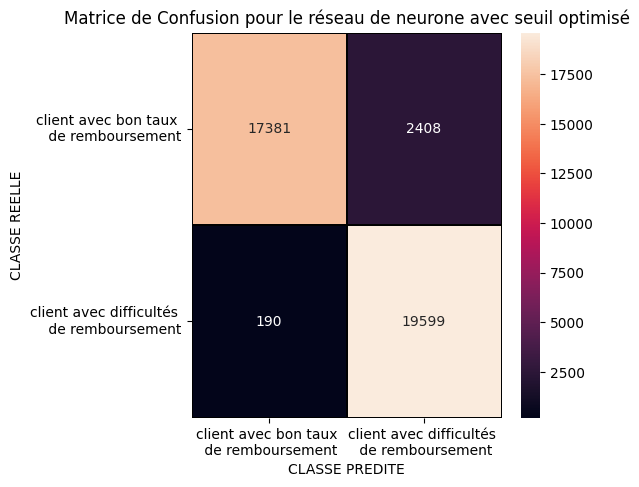

In [110]:
# Graphique de la matrice de confusion
cm_neuron = confusion_matrix(y_train_eq, y_neuron_opt)

x_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
y_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm_neuron, annot=True, linewidths=0.2, linecolor="black",
                fmt=".0f", ax=ax,
                xticklabels=x_axis_labels,
                yticklabels=y_axis_labels)
plt.yticks(rotation=0)
plt.ylabel("CLASSE REELLE")
plt.xlabel("CLASSE PREDITE")
plt.title('Matrice de Confusion pour le réseau de neurone avec seuil optimisé')
plt.show()

Ici, on voit que les FN ont été minimisés comme nous le souhaitions.

Passons à la prédiction sur les données de test avec le modèle et le seuil de décision optimisés :

In [111]:
# prédiction sur les données de test avec les meilleurs hyperparamètres et le seuil optimisé
y_pred_neuron_gd = (best_model_neuron_gs.predict_proba(X_test_norm)[:,1] >= seuil_opt_neuron).astype(int)
y_prob_neuron_gd = best_model_neuron_gs.predict_proba(X_test_norm)[:, 1]

In [112]:
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_neuron_gd)))
print('Precision Score : ' + str(precision_score(y_test,y_pred_neuron_gd)))
print('Recall Score : ' + str(recall_score(y_test,y_pred_neuron_gd)))
print('F1 Score : ' + str(f1_score(y_test,y_pred_neuron_gd)))
print('F beta Score (avec beta=3) : ' + str(fbeta_score(y_test,y_pred_neuron_gd, beta=3)))
print('Aire sous la courbe ROC : ' +str(roc_auc_score(y_test,y_pred_neuron_gd)))
print('Aire sous la courbe PR : ' +str(average_precision_score(y_test, y_prob_neuron_gd)))

Accuracy Score : 0.5145114872445247
Precision Score : 0.11658583299867165
Recall Score : 0.7494042891183479
F1 Score : 0.20178041543026706
F beta Score (avec beta=3) : 0.48574554347126586
Aire sous la courbe ROC : 0.6214834504546527
Aire sous la courbe PR : 0.15892195783513421


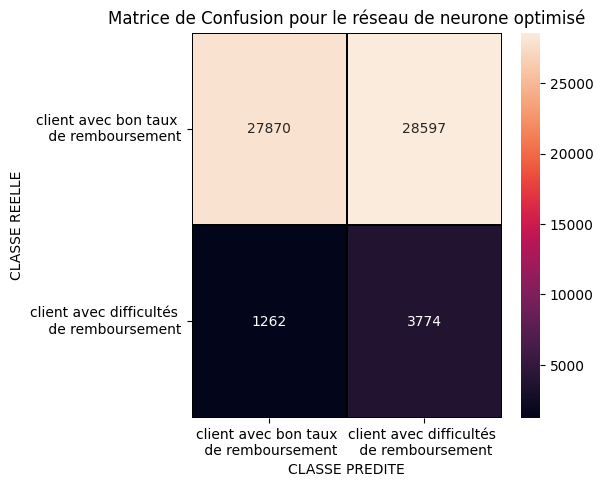

In [113]:
# Graphique de la matrice de confusion
cm_neuron = confusion_matrix(y_test, y_pred_neuron_gd)

x_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
y_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm_neuron, annot=True, linewidths=0.2, linecolor="black",
                fmt=".0f", ax=ax,
                xticklabels=x_axis_labels,
                yticklabels=y_axis_labels)
plt.yticks(rotation=0)
plt.ylabel("CLASSE REELLE")
plt.xlabel("CLASSE PREDITE")
plt.title('Matrice de Confusion pour le réseau de neurone optimisé')
plt.show()

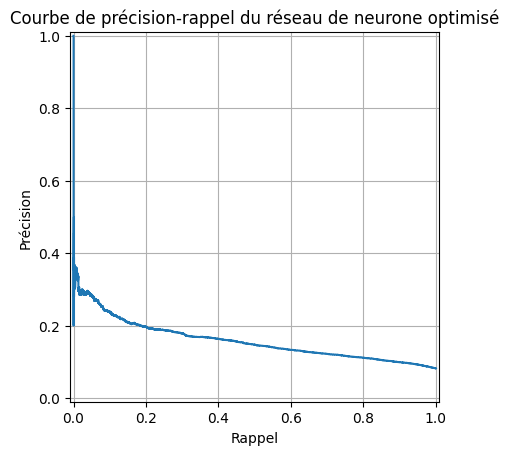

In [114]:
# Graphique précision-rappel
precision_neuron, recall_neuron, _ = precision_recall_curve(y_test, y_prob_neuron_gd)
disp_neuron = PrecisionRecallDisplay(precision=precision_neuron, recall=recall_neuron)
disp_neuron.plot()
plt.xlabel('Rappel')
plt.ylabel('Précision')
plt.title('Courbe de précision-rappel du réseau de neurone optimisé')
plt.grid(True)
plt.show()

Text(0.5, 1.0, 'Courbe ROC du réseau de neurone optimisé')

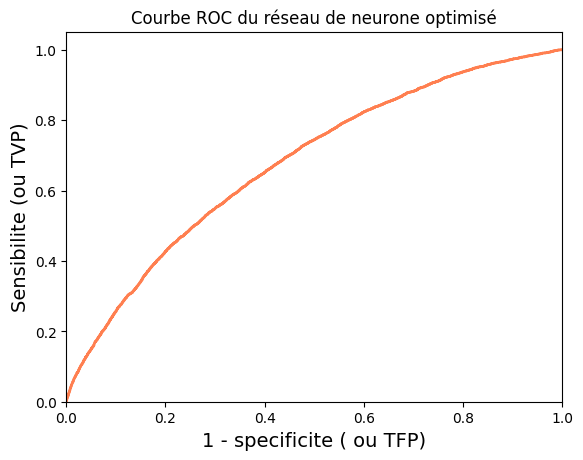

In [115]:
# Graphique courbe ROC
[fpr_neuron, tpr_neuron, thr_neuron] = metrics.roc_curve(y_test, y_prob_neuron_gd)
plt.plot(fpr_neuron, tpr_neuron, color='coral', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - specificite ( ou TFP)', fontsize=14)
plt.ylabel('Sensibilite (ou TVP)', fontsize=14)
plt.title('Courbe ROC du réseau de neurone optimisé')

Text(0.5, 0, "Top 20 des variables avec le plus d'importance")

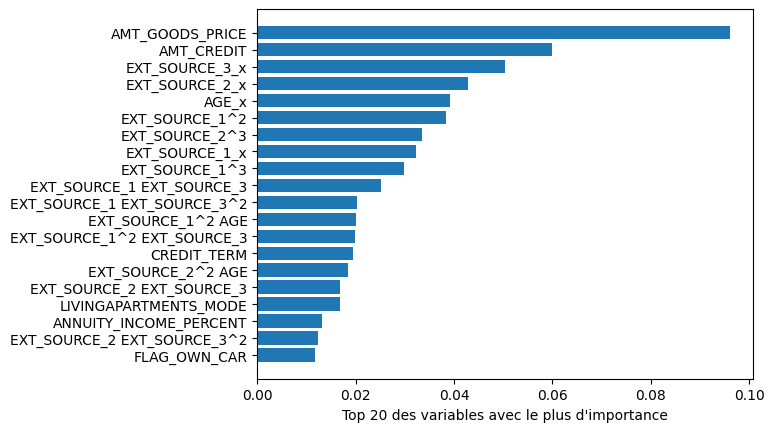

In [116]:
# Graphique des 20 variables qui ont le plus d'importance pour ce modèle optimisé
perm_importance_neuron = permutation_importance(best_model_neuron_gs, X_train_eq,y_train_eq)

feature_names = X_train_eq.columns
features = np.array(feature_names)

sorted_idx_neuron = abs(perm_importance_neuron.importances_mean).argsort()
plt.barh(features[sorted_idx_neuron[-20:]], perm_importance_neuron.importances_mean[sorted_idx_neuron[-20:]])
plt.xlabel("Top 20 des variables avec le plus d'importance")

Nous pouvons voir que les données "AMT_GOODS_PRICE", "AMT_CREDIT", "AGE"et "EXT_SOURCE" ont une importance élevée dans ce modèle optimisé de réseau de neurones.


### Modèles ensembliste de forêts aléatoires (Random Forest):


La base du calcul repose sur l'apprentissage par arbres de décision partiellement indépendants les uns des autres.

Pour chaque arbre à créer :

- On crée un échantillon en tirant avec remise autant d'observations que le jeu de données inital (technique connue sous le nom de  bagging, aussi appelé bootstrap aggregating ),
- Sur toutes les variables, on n'en retient qu'un plus petit nombre au hasard.
- On entraîne un arbre de décision à partir de l'échantillon créé en ne tenant compte que des variables sélectionnées. On limite la croissance de l'arbre de décision par validation croisée.

In [117]:
# Création d'une instance de modèle de forêt aléatoire
rfc = RandomForestClassifier(n_estimators=500,random_state=42)

# On entraîne ce modèle sur les données d'entrainement
rfc.fit(X_train_eq,y_train_eq)
y_pred_rfc = rfc.predict(X_test_norm)

In [118]:
# score de la forêt aléatoire
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_rfc)))
print('Precision Score : ' + str(precision_score(y_test,y_pred_rfc)))
print('Recall Score : ' + str(recall_score(y_test,y_pred_rfc)))
print('F1 Score : ' + str(f1_score(y_test,y_pred_rfc)))
print('F beta Score (avec beta=3) : ' + str(fbeta_score(y_test,y_pred_rfc, beta=3)))
print('Aire sous la courbe ROC : ' +str(roc_auc_score(y_test,y_pred_rfc)))
print('Aire sous la courbe PR : ' +str(average_precision_score(y_test, y_pred_rfc)))

Accuracy Score : 0.6877225501195063
Precision Score : 0.16348437351572148
Recall Score : 0.6834789515488483
F1 Score : 0.2638558834802606
F beta Score (avec beta=3) : 0.5185453011539968
Aire sous la courbe ROC : 0.6857899831504136
Aire sous la courbe PR : 0.13765556312701935


In [119]:
rfc = RandomForestClassifier( random_state=42)
params={"max_depth": [None] + list(range(2, 20, 3)),"max_features": ["auto", "sqrt", "log2"],"n_estimators":[100,500,1000]}

# optimisation des paramètres avec la grid search
grid_rfc = GridSearchCV(rfc, params,cv=3, n_jobs=-1)
grid_rfc.fit(X_train_eq,y_train_eq)

#récupération des meilleurs hyperparamètres
best_model_rfc_gs = grid_rfc.best_estimator_

In [120]:
print(best_model_rfc_gs)

RandomForestClassifier(max_depth=17, n_estimators=1000, random_state=42)


In [121]:
print(grid_rfc.best_params_)

{'max_depth': 17, 'max_features': 'sqrt', 'n_estimators': 1000}


In [122]:
cvres_rfc=pd.DataFrame(grid_rfc.cv_results_)
cvres_rfc

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.128340,0.019917,0.000000,0.000000,NaN,auto,100,"{'max_depth': None, 'max_features': 'auto', 'n...",NaN,NaN,NaN,NaN,NaN,43
1,0.146497,0.004583,0.000000,0.000000,NaN,auto,500,"{'max_depth': None, 'max_features': 'auto', 'n...",NaN,NaN,NaN,NaN,NaN,43
2,0.139850,0.003665,0.000000,0.000000,NaN,auto,1000,"{'max_depth': None, 'max_features': 'auto', 'n...",NaN,NaN,NaN,NaN,NaN,43
3,28.952753,2.098111,0.969050,0.152619,NaN,sqrt,100,"{'max_depth': None, 'max_features': 'sqrt', 'n...",0.669825,0.667096,0.677759,0.671560,0.004523,27
4,144.871164,12.380463,4.291196,0.522857,NaN,sqrt,500,"{'max_depth': None, 'max_features': 'sqrt', 'n...",0.676874,0.670583,0.679730,0.675729,0.003821,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,112.959263,6.835766,2.989736,0.131534,17.0,sqrt,500,"{'max_depth': 17, 'max_features': 'sqrt', 'n_e...",0.676040,0.674449,0.681474,0.677321,0.003008,2
59,179.812259,1.359305,1.968536,0.233522,17.0,sqrt,1000,"{'max_depth': 17, 'max_features': 'sqrt', 'n_e...",0.677101,0.671796,0.684203,0.677700,0.005083,1
60,13.755605,1.472924,0.756838,0.119585,17.0,log2,100,"{'max_depth': 17, 'max_features': 'log2', 'n_e...",0.673918,0.669977,0.676925,0.673607,0.002845,21
61,57.241182,2.185077,2.251081,0.375938,17.0,log2,500,"{'max_depth': 17, 'max_features': 'log2', 'n_e...",0.674828,0.670734,0.680488,0.675350,0.003999,11


In [123]:
cols= [i for i in cvres_rfc.columns if "split" not in i ]
cvres_rfc=cvres_rfc [cols].sort_values("rank_test_score")
cvres_rfc.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_n_estimators,params,mean_test_score,std_test_score,rank_test_score
59,179.812259,1.359305,1.968536,0.233522,17.0,sqrt,1000,"{'max_depth': 17, 'max_features': 'sqrt', 'n_e...",0.677700,0.005083,1
58,112.959263,6.835766,2.989736,0.131534,17.0,sqrt,500,"{'max_depth': 17, 'max_features': 'sqrt', 'n_e...",0.677321,0.003008,2
7,73.034835,0.938565,4.534023,0.231068,NaN,log2,500,"{'max_depth': None, 'max_features': 'log2', 'n...",0.676816,0.003915,3
5,279.096775,6.974477,8.951481,1.097241,NaN,sqrt,1000,"{'max_depth': None, 'max_features': 'sqrt', 'n...",0.676740,0.003282,4
8,152.778542,2.393066,7.591561,0.189361,NaN,log2,1000,"{'max_depth': None, 'max_features': 'log2', 'n...",0.676689,0.003791,5
50,197.518440,12.736445,6.014868,1.049229,14.0,sqrt,1000,"{'max_depth': 14, 'max_features': 'sqrt', 'n_e...",0.676664,0.004318,6
49,104.420476,1.379973,3.034499,0.374341,14.0,sqrt,500,"{'max_depth': 14, 'max_features': 'sqrt', 'n_e...",0.676108,0.004122,7
4,144.871164,12.380463,4.291196,0.522857,NaN,sqrt,500,"{'max_depth': None, 'max_features': 'sqrt', 'n...",0.675729,0.003821,8
53,110.715943,9.005937,6.964719,1.328870,14.0,log2,1000,"{'max_depth': 14, 'max_features': 'log2', 'n_e...",0.675577,0.002956,9
62,87.094677,5.003341,2.819112,0.290030,17.0,log2,1000,"{'max_depth': 17, 'max_features': 'log2', 'n_e...",0.675527,0.003889,10


Les hyperparamètres optimisés correspondent au deux couple de paramètres suivants {'max_depth': 17,'n_estimators':1000, 'max_features': 'sqrt'} et entrainent une maximisation du mean_test_score égal à 0.677700.


La troisième combinaison {'max_depth': NaN,'n_estimators':500, 'max_features': 'log2'} est également à considérer car elle est beaucoup plus rapide pour un résultat quasiment similaire.

Maintenant, cherchons à optimiser le seuil de décision de l'algorithme en cherchant à minimiser au maximum le taux de FN, donc en maximisant le recall ou,ici, le f beta score avec beta =3.

In [124]:
# prédiction sur les données d'entrainement avec les meilleurs hyperparamètres
y_prob_train_rfc_gd = best_model_rfc_gs.predict_proba(X_train_eq)[:, 1]
y_pred_train_rfc_gd = best_model_rfc_gs.predict(X_train_eq)

In [125]:
# F3 score selon les différents seuils de décision
f3_score_rfc=[]
for i in [x / 100.0 for x in range(0, 100, 1)]:
  preds=(np.where(y_prob_train_rfc_gd > i, 1, 0))
  f3_score_rfc.append(str(fbeta_score(y_train_eq,preds, beta=3)))

In [126]:
df=pd.DataFrame(data={'abs': [x / 100.0 for x in range(0, 100, 1)], 'f3_score': f3_score_rfc})
df['f3_score']=df['f3_score'].astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   abs       100 non-null    float64
 1   f3_score  100 non-null    float64
dtypes: float64(2)
memory usage: 1.7 KB


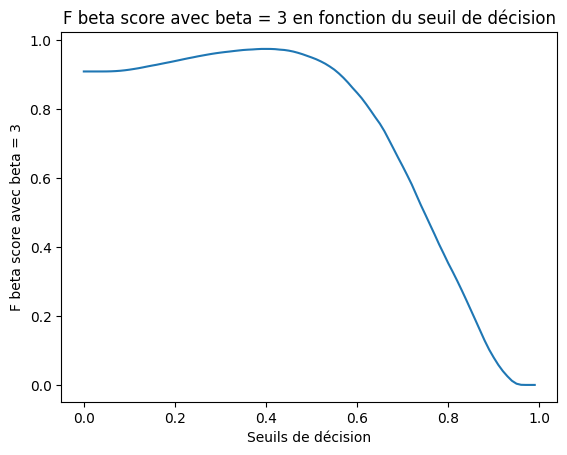

In [127]:
# Affichage des valeurs du F3 score en fonction des différents seuils de décision
plt.plot(df['abs'], df['f3_score'])
plt.title('F beta score avec beta = 3 en fonction du seuil de décision')
plt.xlabel('Seuils de décision')
plt.ylabel('F beta score avec beta = 3')
plt.show()

La solution visuelle n'est pas suffisante pour trouver le bon seuil, cherchons sa valeur numérique.

In [128]:
# Cherchons la valeur maximale du F3 score
f3_score_rfc_max=df['f3_score'].max()
# Cherchons la valeur du seuil correspondant au F3 score max
seuil_opt_rfc=df.loc[df['f3_score']==f3_score_rfc_max,['abs']]
seuil_opt_rfc=seuil_opt_rfc.values[0,0]
seuil_opt_rfc

0.4

In [129]:
# Récupération des prédictions correspondantes au nouveau seuil de décision
y_rfc_opt=(y_prob_train_rfc_gd> seuil_opt_rfc).astype(int)

In [130]:
# score de la régression logistique avec seuil de décision optimisé
print('Accuracy Score : ' + str(accuracy_score(y_train_eq,y_rfc_opt)))
print('Precision Score : ' + str(precision_score(y_train_eq,y_rfc_opt)))
print('Recall Score : ' + str(recall_score(y_train_eq,y_rfc_opt)))
print('F1 Score : ' + str(f1_score(y_train_eq,y_rfc_opt)))
print('F beta Score (avec beta=3) : ' + str(fbeta_score(y_train_eq,y_rfc_opt, beta=3)))
print('Aire sous la courbe ROC : ' +str(roc_auc_score(y_train_eq,y_rfc_opt)))
print('Aire sous la courbe PR : ' +str(average_precision_score(y_train_eq, y_rfc_opt)))

Accuracy Score : 0.9026226691596342
Precision Score : 0.8416448694309849
Recall Score : 0.9918641669614432
F1 Score : 0.9106007886801206
F beta Score (avec beta=3) : 0.9744715075810984
Aire sous la courbe ROC : 0.9026226691596342
Aire sous la courbe PR : 0.8388653038148149


Nous voyons bien que le F3 score ainsi que le recall ont été maximisé grâce à ce nouveau seuil de 0,4.

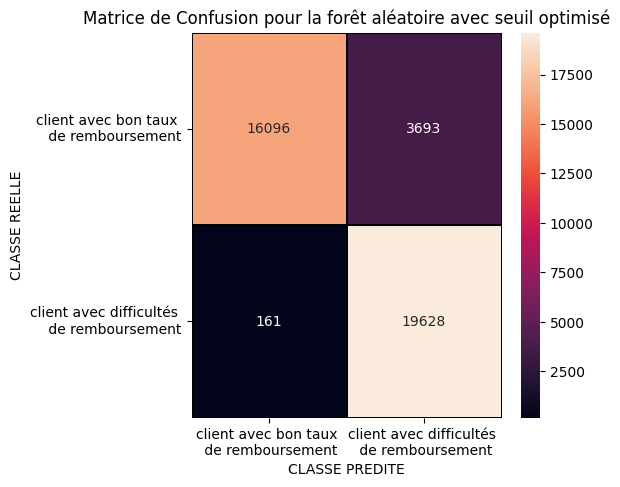

In [131]:
# Graphique de la matrice de confusion
cm_rfc = confusion_matrix(y_train_eq, y_rfc_opt)

x_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
y_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm_rfc, annot=True, linewidths=0.2, linecolor="black",
                fmt=".0f", ax=ax,
                xticklabels=x_axis_labels,
                yticklabels=y_axis_labels)
plt.yticks(rotation=0)
plt.ylabel("CLASSE REELLE")
plt.xlabel("CLASSE PREDITE")
plt.title('Matrice de Confusion pour la forêt aléatoire avec seuil optimisé')
plt.show()

Ici, on voit que les FN ont été minimisés comme nous le souhaitions.

Passons à la prédiction sur les données de test avec le modèle et le seuil de décision optimisés :

In [168]:
# prédiction sur les données de test avec les meilleurs hyperparamètres et le seuil optimisé
y_pred_rfc_gd = (best_model_rfc_gs.predict_proba(X_test_norm)[:,1] >= seuil_opt_rfc).astype(int)
y_prob_rfc_gd = best_model_rfc_gs.predict_proba(X_test_norm)[:, 1]

In [133]:
# score de la forêt aléatoire avec hyperparamètres optimisés
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_rfc_gd)))
print('Precision Score : ' + str(precision_score(y_test,y_pred_rfc_gd)))
print('Recall Score : ' + str(recall_score(y_test,y_pred_rfc_gd)))
print('F1 Score : ' + str(f1_score(y_test,y_pred_rfc_gd)))
print('F beta Score (avec beta=3) : ' + str(fbeta_score(y_test,y_pred_rfc_gd, beta=3)))
print('Aire sous la courbe ROC : ' +str(roc_auc_score(y_test,y_prob_rfc_gd)))
print('Aire sous la courbe PR : ' +str(average_precision_score(y_test, y_prob_rfc_gd)))

Accuracy Score : 0.5216981285465749
Precision Score : 0.12739554360118593
Recall Score : 0.8276409849086577
F1 Score : 0.2208036447434641
F beta Score (avec beta=3) : 0.5340782409246422
Aire sous la courbe ROC : 0.74480334644907
Aire sous la courbe PR : 0.2222425401226171


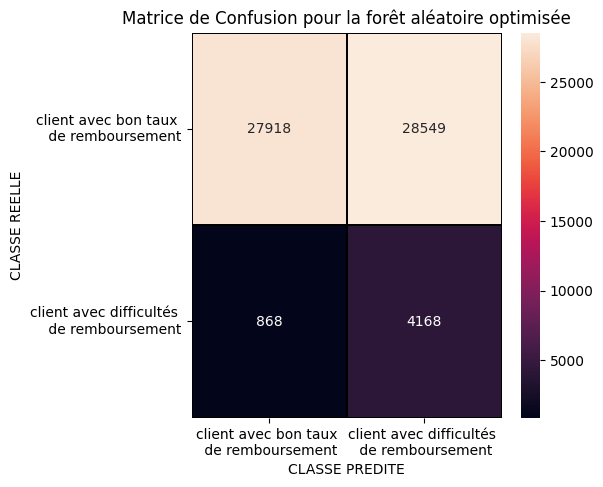

In [134]:
# Graphique de la matrice de confusion
cm_rfc = confusion_matrix(y_test, y_pred_rfc_gd)

x_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
y_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm_rfc, annot=True, linewidths=0.2, linecolor="black",
                fmt=".0f", ax=ax,
                xticklabels=x_axis_labels,
                yticklabels=y_axis_labels)
plt.yticks(rotation=0)
plt.ylabel("CLASSE REELLE")
plt.xlabel("CLASSE PREDITE")
plt.title('Matrice de Confusion pour la forêt aléatoire optimisée')
plt.show()

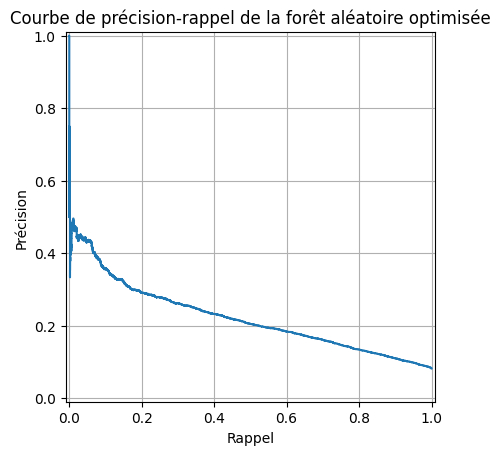

In [135]:
# Graphique précision-rappel
precision_rfc, recall_rfc, _ = precision_recall_curve(y_test, y_prob_rfc_gd)
disp_rfc = PrecisionRecallDisplay(precision=precision_rfc, recall=recall_rfc)
disp_rfc.plot()
plt.xlabel('Rappel')
plt.ylabel('Précision')
plt.title('Courbe de précision-rappel de la forêt aléatoire optimisée')
plt.grid(True)
plt.show()

Text(0.5, 1.0, 'Courbe ROC de la forêt aléatoire optimisée')

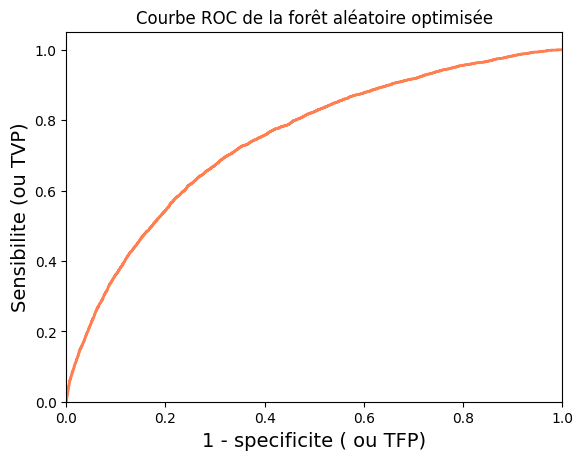

In [136]:
# Graphique courbe ROC
[fpr_rfc, tpr_rfc, thr_rfc] = metrics.roc_curve(y_test, y_prob_rfc_gd)
plt.plot(fpr_rfc, tpr_rfc, color='coral', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - specificite ( ou TFP)', fontsize=14)
plt.ylabel('Sensibilite (ou TVP)', fontsize=14)
plt.title('Courbe ROC de la forêt aléatoire optimisée')

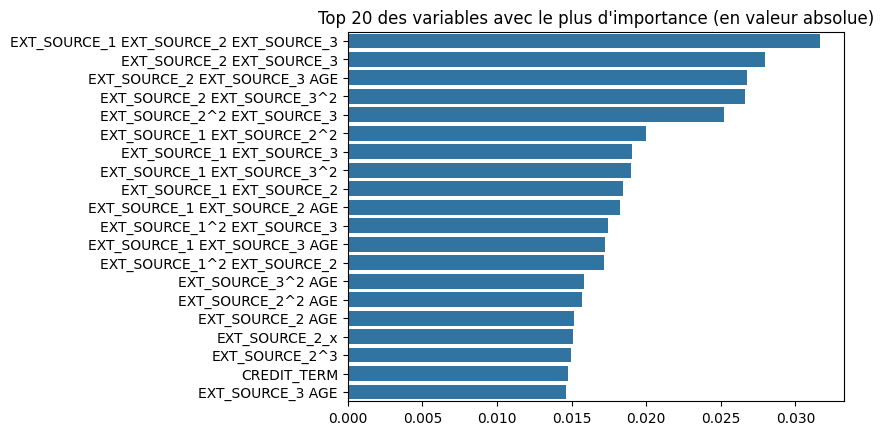

In [137]:
# Graphique des 20 variables qui ont le plus d'importance pour ce modèle optimisé
top_coefficients_rfc = (pd.Series(best_model_rfc_gs.feature_importances_,X_train_eq.columns).map(abs).sort_values(ascending=False).head(20))
sns.barplot(data=top_coefficients_rfc, orient="y")
plt.title("Top 20 des variables avec le plus d'importance (en valeur absolue)")
plt.show()

Nous pouvons voir que les combinaisons créées avec les données EXT_SOURCE et AGE ont une importance élevée dans ce modèle optimisé de forêt aléatoire.


In [138]:
#  Sélection du seuil pour diminuer le nombre de variables si nombre de lignes peu important et risque d'overfitting

# from sklearn.feature_selection import SelectFromModel
# select = SelectFromModel(rfc.fit(X_train_eq,y_train_eq), prefit=True, threshold=0.01)
# X_train2 = select.transform(X_train_eq)
# print(X_train2.shape)

# avec boucle
# selectbislist=[]
# Xtrainbis=[]
# for i in [x / 1000.0 for x in range(5, 26, 5)]   :
#   selectbis=SelectFromModel(best_model_rfc_gs, prefit=True, threshold=i)
#   selectbislist.append(selectbis)
#   temp=selectbis.transform(X_train_eq)
#   Xtrainbis.append(temp)

### Modèles ensembliste séquentiel du XGBoost:

Le boosting va produire des modèles qui sont très dépendants les uns des autres, contrairement au principe du bagging. En effet les modèles sont entraînés itérativement comme suit :

- La première étape consiste à créer un premier modèle de base partir d'un algorithme choisi. Il est entraîné sur les données. Au début, on attribue des poids égaux à toutes les observations. À partir des résultats obtenus de ce modèle, si une observation est mal classée, cela augmente son poids.

- Ensuite, un second modèle est construit pour tenter de corriger les erreurs présentes dans le premier modèle. Il est entraîné à l'aide des données pondérées obtenues dans la première étape. Cette procédure se poursuit et des modèles sont ajoutés jusqu’à ce que l’ensemble complet des données de formation soit prédit correctement ou que le nombre maximal de modèles soit ajouté.

- Les prédictions du dernier modèle ajouté seront les prédictions globales pondérées fournies par les anciens modèles d’arbres.


In [139]:
# Création d'une instance de modèle de XGBoost
bst = XGBClassifier( max_depth=20, learning_rate=1, objective='binary:logistic')

# On entraîne ce modèle sur les données d'entrainement
bst.fit(X_train_eq,y_train_eq)
y_pred_bst = bst.predict(X_test_norm)

In [140]:
# score du XGBoost
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_bst)))
print('Precision Score : ' + str(precision_score(y_test,y_pred_bst)))
print('Recall Score : ' + str(recall_score(y_test,y_pred_bst)))
print('F1 Score : ' + str(f1_score(y_test,y_pred_bst)))
print('F beta Score (avec beta=3) : ' + str(fbeta_score(y_test,y_pred_bst, beta=3)))
print('Aire sous la courbe ROC : ' +str(roc_auc_score(y_test,y_pred_bst)))
print('Aire sous la courbe PR : ' +str(average_precision_score(y_test, y_pred_bst)))

Accuracy Score : 0.6543095458758109
Precision Score : 0.1464063112932049
Recall Score : 0.6669976171564734
F1 Score : 0.2401086529182601
F beta Score (avec beta=3) : 0.4920386130927095
Aire sous la courbe ROC : 0.6600877897530822
Aire sous la courbe PR : 0.12491962335642742


In [141]:
bst = XGBClassifier( objective='binary:logistic', random_state=42)
params={"learning_rate" : [0.1,0.5,1],"max_depth": [None] + list(range(2, 10, 2))}

# optimisation des paramètres avec la grid search
grid_bst = GridSearchCV(bst, params,cv=3, n_jobs=-1)
grid_bst.fit(X_train_eq,y_train_eq)

#récupération des meilleurs hyperparamètres
best_model_bst_gs = grid_bst.best_estimator_

In [142]:
print(best_model_bst_gs)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)


In [143]:
print(grid_bst.best_params_)

{'learning_rate': 0.1, 'max_depth': 4}


In [144]:
cvres_bst=pd.DataFrame(grid_bst.cv_results_)
cvres_bst

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,4.710996,0.311631,0.149949,0.020930,0.1,NaN,"{'learning_rate': 0.1, 'max_depth': None}",0.687789,0.684075,0.690646,0.687503,0.002690,2
1,2.791736,0.198751,0.178458,0.075645,0.1,2.0,"{'learning_rate': 0.1, 'max_depth': 2}",0.680967,0.680664,0.688296,0.683309,0.003528,6
2,3.638897,0.075784,0.152905,0.014018,0.1,4.0,"{'learning_rate': 0.1, 'max_depth': 4}",0.686197,0.683772,0.694360,0.688110,0.004529,1
3,5.409311,0.254005,0.191826,0.013321,0.1,6.0,"{'learning_rate': 0.1, 'max_depth': 6}",0.687789,0.684075,0.690646,0.687503,0.002690,2
4,10.784716,0.097907,0.271466,0.045562,0.1,8.0,"{'learning_rate': 0.1, 'max_depth': 8}",0.685060,0.685136,0.688523,0.686240,0.001615,5
5,6.358553,0.117335,0.290391,0.019222,0.5,NaN,"{'learning_rate': 0.5, 'max_depth': None}",0.654211,0.660502,0.669951,0.661555,0.006469,9
6,3.810485,0.027127,0.303332,0.040350,0.5,2.0,"{'learning_rate': 0.5, 'max_depth': 2}",0.683317,0.684378,0.694284,0.687326,0.004939,4
7,3.613421,0.301634,0.221892,0.013889,0.5,4.0,"{'learning_rate': 0.5, 'max_depth': 4}",0.677253,0.677101,0.680033,0.678129,0.001348,7
8,4.251740,0.201842,0.108299,0.011378,0.5,6.0,"{'learning_rate': 0.5, 'max_depth': 6}",0.654211,0.660502,0.669951,0.661555,0.006469,9
9,7.330897,0.156017,0.130481,0.027709,0.5,8.0,"{'learning_rate': 0.5, 'max_depth': 8}",0.656409,0.654741,0.657292,0.656147,0.001058,11


In [145]:
cols= [i for i in cvres_bst.columns if "split" not in i ]
cvres_bst=cvres_bst [cols].sort_values("rank_test_score")
cvres_bst.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,params,mean_test_score,std_test_score,rank_test_score
2,3.638897,0.075784,0.152905,0.014018,0.1,4.0,"{'learning_rate': 0.1, 'max_depth': 4}",0.688110,0.004529,1
0,4.710996,0.311631,0.149949,0.020930,0.1,NaN,"{'learning_rate': 0.1, 'max_depth': None}",0.687503,0.002690,2
3,5.409311,0.254005,0.191826,0.013321,0.1,6.0,"{'learning_rate': 0.1, 'max_depth': 6}",0.687503,0.002690,2
6,3.810485,0.027127,0.303332,0.040350,0.5,2.0,"{'learning_rate': 0.5, 'max_depth': 2}",0.687326,0.004939,4
4,10.784716,0.097907,0.271466,0.045562,0.1,8.0,"{'learning_rate': 0.1, 'max_depth': 8}",0.686240,0.001615,5
1,2.791736,0.198751,0.178458,0.075645,0.1,2.0,"{'learning_rate': 0.1, 'max_depth': 2}",0.683309,0.003528,6
7,3.613421,0.301634,0.221892,0.013889,0.5,4.0,"{'learning_rate': 0.5, 'max_depth': 4}",0.678129,0.001348,7
11,2.078036,0.331528,0.088419,0.004963,1.0,2.0,"{'learning_rate': 1, 'max_depth': 2}",0.676411,0.006275,8
5,6.358553,0.117335,0.290391,0.019222,0.5,NaN,"{'learning_rate': 0.5, 'max_depth': None}",0.661555,0.006469,9
8,4.251740,0.201842,0.108299,0.011378,0.5,6.0,"{'learning_rate': 0.5, 'max_depth': 6}",0.661555,0.006469,9


Les hyperparamètres optimisés correspondent au couple de paramètres suivants {'learning_rate': 0.1, 'max_depth': 4} et entrainent une maximisation du mean_test_score égal à 0.688110.

Maintenant, cherchons à optimiser le seuil de décision de l'algorithme en cherchant à minimiser au maximum le taux de FN, donc en maximisant le recall ou,ici, le f beta score avec beta =3.

In [146]:
# prédiction sur les données d'entrainement avec les meilleurs hyperparamètres
y_prob_train_bst_gd = best_model_bst_gs.predict_proba(X_train_eq)[:, 1]
y_pred_train_bst_gd = best_model_bst_gs.predict(X_train_eq)

In [147]:
# F3 score selon les différents seuils de décision
f3_score_bst=[]
for i in [x / 100.0 for x in range(0, 100, 1)]:
  preds=(np.where(y_prob_train_bst_gd > i, 1, 0))
  f3_score_bst.append(str(fbeta_score(y_train_eq,preds, beta=3)))


In [148]:
df=pd.DataFrame(data={'abs': [x / 100.0 for x in range(0, 100, 1)], 'f3_score': f3_score_bst})
df['f3_score']=df['f3_score'].astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   abs       100 non-null    float64
 1   f3_score  100 non-null    float64
dtypes: float64(2)
memory usage: 1.7 KB


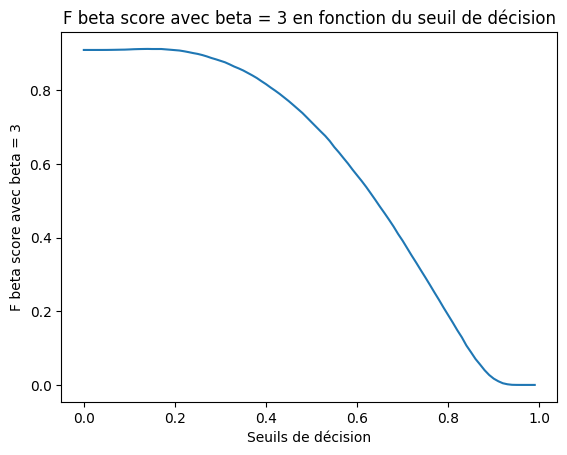

In [149]:
# Affichage des valeurs du F3 score en fonction des différents seuils de décision
plt.plot(df['abs'], df['f3_score'])
plt.title('F beta score avec beta = 3 en fonction du seuil de décision')
plt.xlabel('Seuils de décision')
plt.ylabel('F beta score avec beta = 3')
plt.show()

La solution visuelle n'est pas suffisante pour trouver le bon seuil, cherchons sa valeur numérique.

In [150]:
# Cherchons la valeur maximale du F3 score
f3_score_bst_max=df['f3_score'].max()
# Cherchons la valeur du seuil correspondant au F3 score max
seuil_opt_bst=df.loc[df['f3_score']==f3_score_bst_max,['abs']]
seuil_opt_bst=seuil_opt_bst.values[0,0]
seuil_opt_bst

0.14

In [151]:
# Récupération des prédictions correspondantes au nouveau seuil de décision
y_bst_opt=(y_prob_train_bst_gd> seuil_opt_bst).astype(int)

In [152]:
# score de la régression logistique avec seuil de décision optimisé
print('Accuracy Score : ' + str(accuracy_score(y_train_eq,y_bst_opt)))
print('Precision Score : ' + str(precision_score(y_train_eq,y_bst_opt)))
print('Recall Score : ' + str(recall_score(y_train_eq,y_bst_opt)))
print('F1 Score : ' + str(f1_score(y_train_eq,y_bst_opt)))
print('F beta Score (avec beta=3) : ' + str(fbeta_score(y_train_eq,y_bst_opt, beta=3)))
print('Aire sous la courbe ROC : ' +str(roc_auc_score(y_train_eq,y_bst_opt)))
print('Aire sous la courbe PR : ' +str(average_precision_score(y_train_eq, y_bst_opt)))

Accuracy Score : 0.5325685987164587
Precision Score : 0.5168933972897172
Recall Score : 0.9965132144120471
F1 Score : 0.680704176734553
F beta Score (avec beta=3) : 0.9118990807021438
Aire sous la courbe ROC : 0.5325685987164586
Aire sous la courbe PR : 0.5168344936355158


Nous voyons bien que le F3 score ainsi que le recall ont été maximisé grâce à ce nouveau seuil de 0,14.

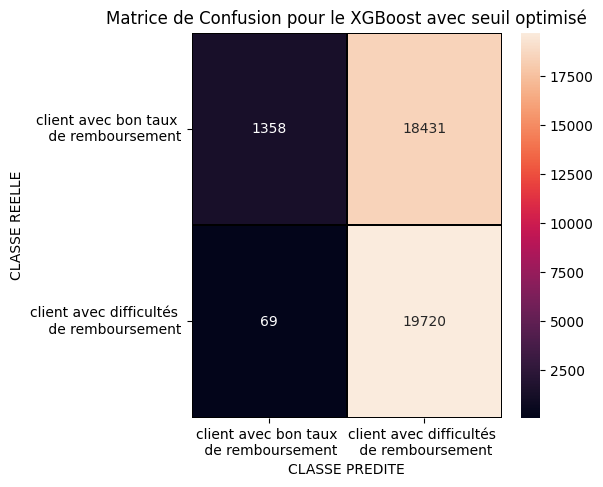

In [153]:
# Graphique de la matrice de confusion
cm_bst = confusion_matrix(y_train_eq, y_bst_opt)

x_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
y_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm_bst, annot=True, linewidths=0.2, linecolor="black",
                fmt=".0f", ax=ax,
                xticklabels=x_axis_labels,
                yticklabels=y_axis_labels)
plt.yticks(rotation=0)
plt.ylabel("CLASSE REELLE")
plt.xlabel("CLASSE PREDITE")
plt.title('Matrice de Confusion pour le XGBoost avec seuil optimisé')
plt.show()

Ici, on voit que les FN ont été minimisés comme nous le souhaitions.

Passons à la prédiction sur les données de test avec le modèle et le seuil de décision optimisés :

In [154]:
# prédiction sur les données de test avec les meilleurs hyperparamètres et le seuil optimisé
y_pred_bst_gd = (best_model_bst_gs.predict_proba(X_test_norm)[:,1] >= seuil_opt_bst).astype(int)
y_prob_bst_gd = best_model_bst_gs.predict_proba(X_test_norm)[:, 1]

In [155]:
# score du XGBoost avec hyperparamètres optimisés
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_bst_gd)))
print('Precision Score : ' + str(precision_score(y_test,y_pred_bst_gd)))
print('Recall Score : ' + str(recall_score(y_test,y_pred_bst_gd)))
print('F1 Score : ' + str(f1_score(y_test,y_pred_bst_gd)))
print('F beta Score (avec beta=3) : ' + str(fbeta_score(y_test,y_pred_bst_gd, beta=3)))
print('Aire sous la courbe ROC : ' +str(roc_auc_score(y_test,y_prob_bst_gd)))
print('Aire sous la courbe PR : ' +str(average_precision_score(y_test, y_prob_bst_gd)))

Accuracy Score : 0.13921272133066678
Precision Score : 0.0863769016905835
Recall Score : 0.9932486100079428
F1 Score : 0.1589324013027246
F beta Score (avec beta=3) : 0.4845349839683047
Aire sous la courbe ROC : 0.7616792877387966
Aire sous la courbe PR : 0.23890182640467753


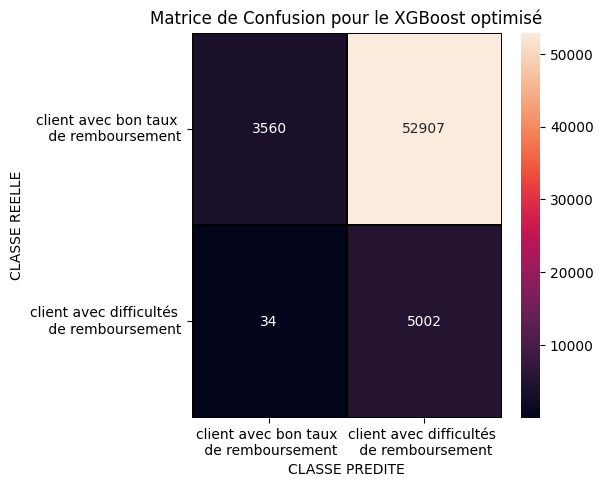

In [156]:
# Graphique de la matrice de confusion
cm_bst = confusion_matrix(y_test, y_pred_bst_gd)

x_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
y_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm_bst, annot=True, linewidths=0.2, linecolor="black",
                fmt=".0f", ax=ax,
                xticklabels=x_axis_labels,
                yticklabels=y_axis_labels)
plt.yticks(rotation=0)
plt.ylabel("CLASSE REELLE")
plt.xlabel("CLASSE PREDITE")
plt.title('Matrice de Confusion pour le XGBoost optimisé')
plt.show()

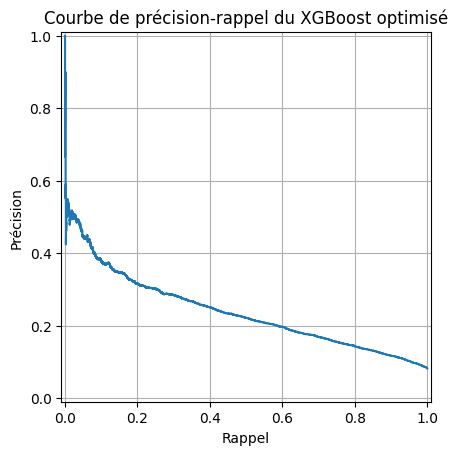

In [157]:
# Graphique précision-rappel
precision_bst, recall_bst, _ = precision_recall_curve(y_test, y_prob_bst_gd)
disp_bst = PrecisionRecallDisplay(precision=precision_bst, recall=recall_bst)
disp_bst.plot()
plt.xlabel('Rappel')
plt.ylabel('Précision')
plt.title('Courbe de précision-rappel du XGBoost optimisé')
plt.grid(True)
plt.show()

Text(0.5, 1.0, 'Courbe ROC du XGBoost optimisé')

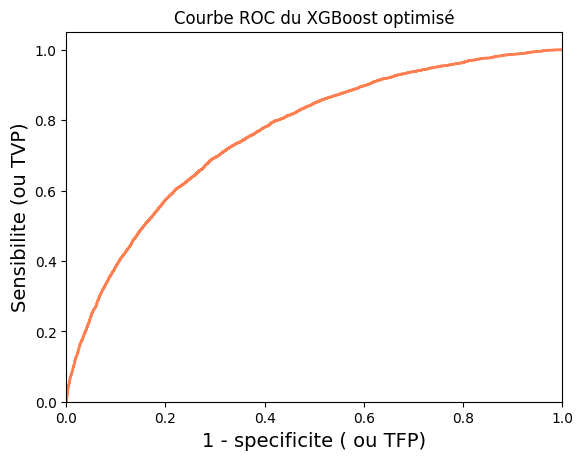

In [158]:
# Graphique courbe ROC
[fpr_bst, tpr_bst, thr_bst] = metrics.roc_curve(y_test, y_prob_bst_gd)
plt.plot(fpr_bst, tpr_bst, color='coral', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - specificite ( ou TFP)', fontsize=14)
plt.ylabel('Sensibilite (ou TVP)', fontsize=14)
plt.title('Courbe ROC du XGBoost optimisé')

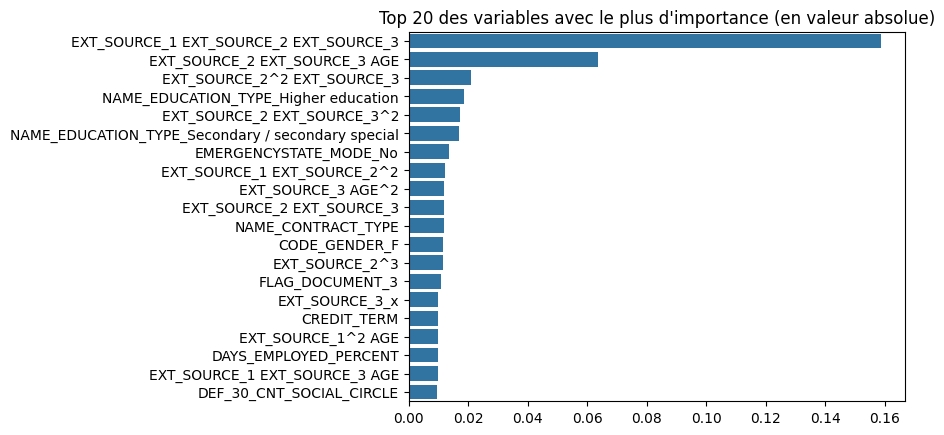

In [159]:
# Graphique des 20 variables qui ont le plus d'importance pour ce modèle optimisé
top_coefficients_bst = (pd.Series(best_model_bst_gs.feature_importances_,X_train_eq.columns).map(abs).sort_values(ascending=False).head(20))
sns.barplot(data=top_coefficients_bst, orient="y")
plt.title("Top 20 des variables avec le plus d'importance (en valeur absolue)")
plt.show()

Nous pouvons voir que la combinaisons créée avec les 3 données EXT_SOURCE a une importance beaucoup plus élevée que toutes les autres dans ce modèle optimisé de XGBoost.


### Choix du modèle :

Puisque notre but est de maximiser le F3 score, l'algorithme de forêt aléatoire semble le mieux adapté avec un F3 score de 0.53408.

Cependant, ses temps d'entrainement et de prédiction sont les plus importants.

Privilégions tout de même la performance et donc l'algorithme de forêt aléatoire dans ce premier temps, ce qui nous permettra également d'avoir une bonne explicabilité.

## Explication du modèle :

Observons maintenant comment les variables les plus importantes influencent les prédictions avec la fonction SHAP.

In [ ]:
explainer = shap.TreeExplainer(best_model_rfc_gs)
shap_values = explainer.shap_values(X_test_norm)

### Global :

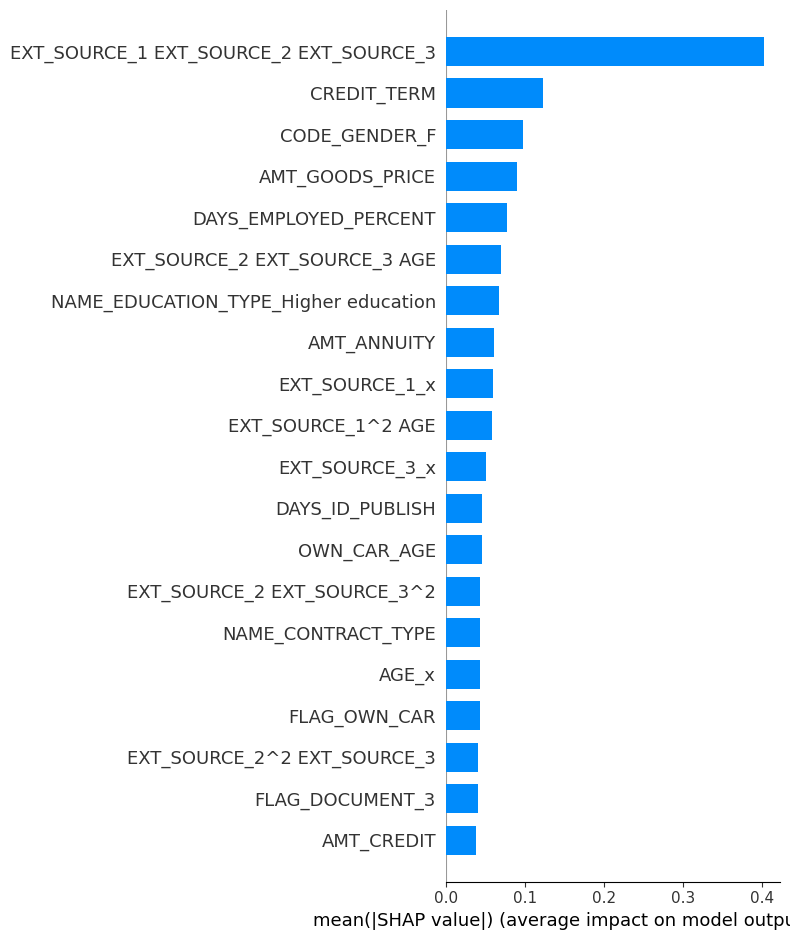

In [161]:
shap.summary_plot(
    shap_values, X_test_norm, feature_names=X_test_norm.columns, plot_type="bar"
)

On trouve quelques différences avec la fonction feature_importance mais on retrouve la combinaison "EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3" qui prédomine.

D'autres combinaisons polynomiales sont les plus influentes ainsi que la variable "CREDIT TERM" que l'on retrouve dans le top 20 du modèle de forêt aléatoire.

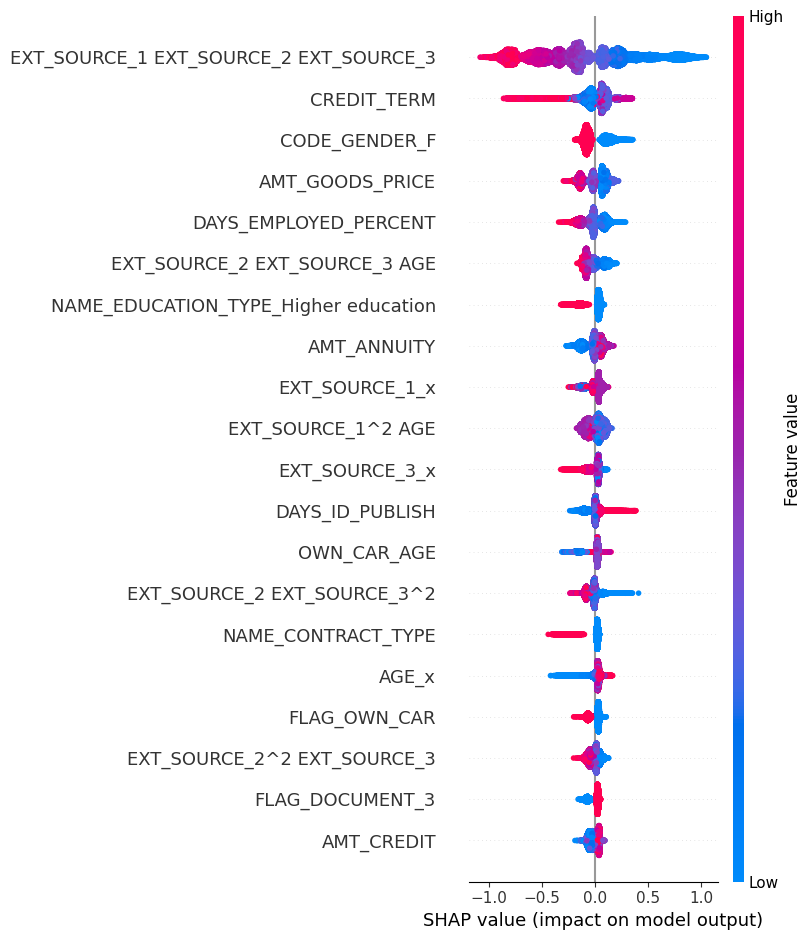

In [162]:
shap.summary_plot(shap_values, X_test_norm)

Avec ce nouveau graphique, on peut voir que la combinaison "EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3" a essentiellement une influence négative sur le modèle quand ces valeurs sont hautes, de même pour CREDIT_TERM. Cela signifie que, lorsque ces variables prennent des valeurs élevées dans une prédiction, il y a de fortes chances que le résultat de la classification soit 0 (classe avec bon taux de remboursement).

Nous pouvons également remarque que le genre féminin a une influence négative sur le modèle.

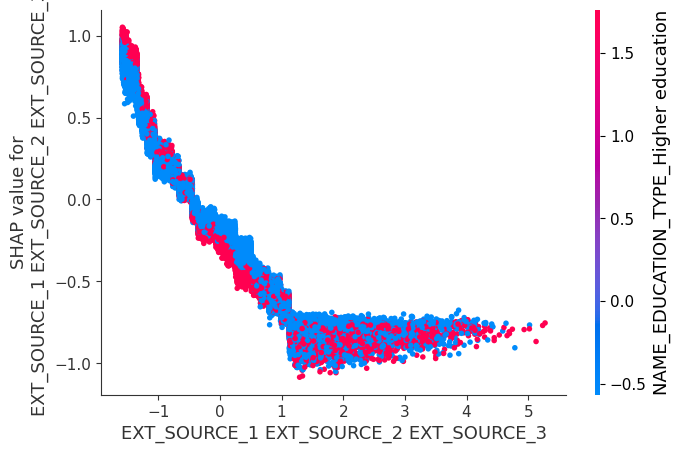

In [163]:
shap.dependence_plot("EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3", shap_values, X_test_norm, interaction_index="auto")

On retrouve le fait que lorsque la valeur de la combinaison "EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3" augmente, la valeur de SHAP de cette combinaison diminue.

Apparemment, la combinaison "EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3" interagit plus avec la variable "NAME_EDUCATION_TYPE_Higher education" qu'avec les autres variables. Cependant, aucune corrélation ne semble pouvoir être déterminée visuellement entre ces deux variables.

### Local :

In [164]:
shap_explainer_values = explainer(X_test_norm, y_test)


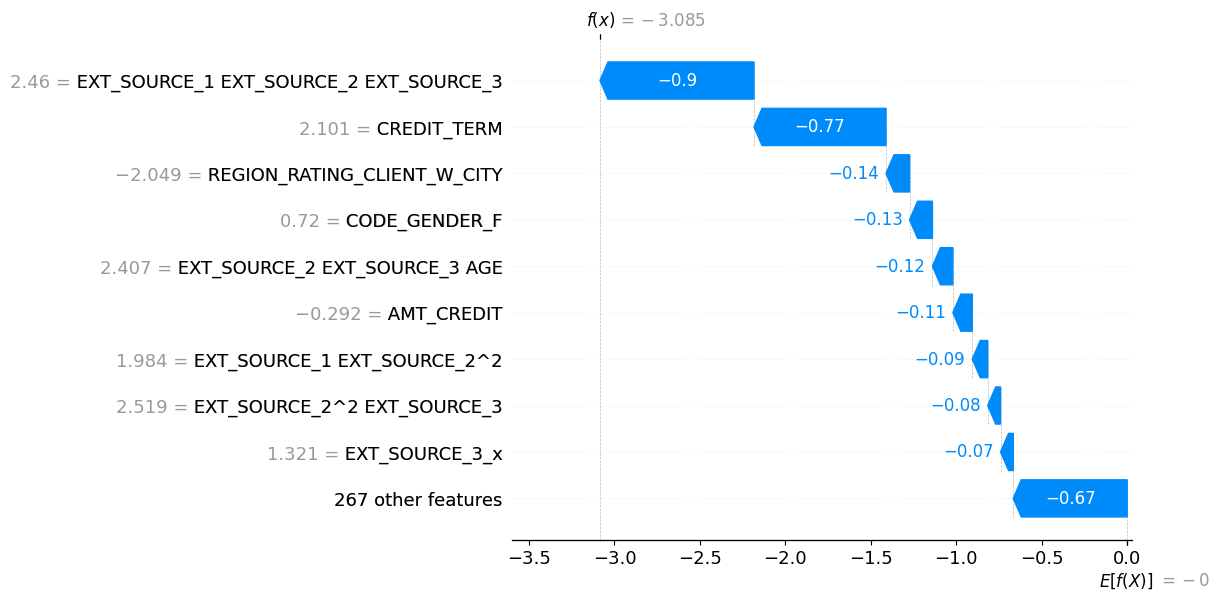

In [165]:
#  Choix d'un individu aléatoire pour l'explication locale
random_idx = np.random.randint(len(X_test_norm))
shap.waterfall_plot(shap_explainer_values[random_idx])

Pour ce premier individu, on peut voir que la prédiction finale est plus fortement influencée négativement par les "autres variables" (-0,67) ainsi que par  la variable "CREDIT TERM" (-0,77) qui a une valeur positive de 2,101 et la combinaison "EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3" (-0,9) qui a une valeur positive de 2,46 (donc une influence négative comme montrée dans l'explication globale au dessus).

Le fait que l'individu soit une femme ("CODE_GENDER_F" positif) influence également de façon négative la variable comme montré dans l'explication globale au dessus.

La prédiction finale est négative (-3,085) et tend à classifier cet individu dans la classe 0 des individus qui ont un bon taux de remboursement.

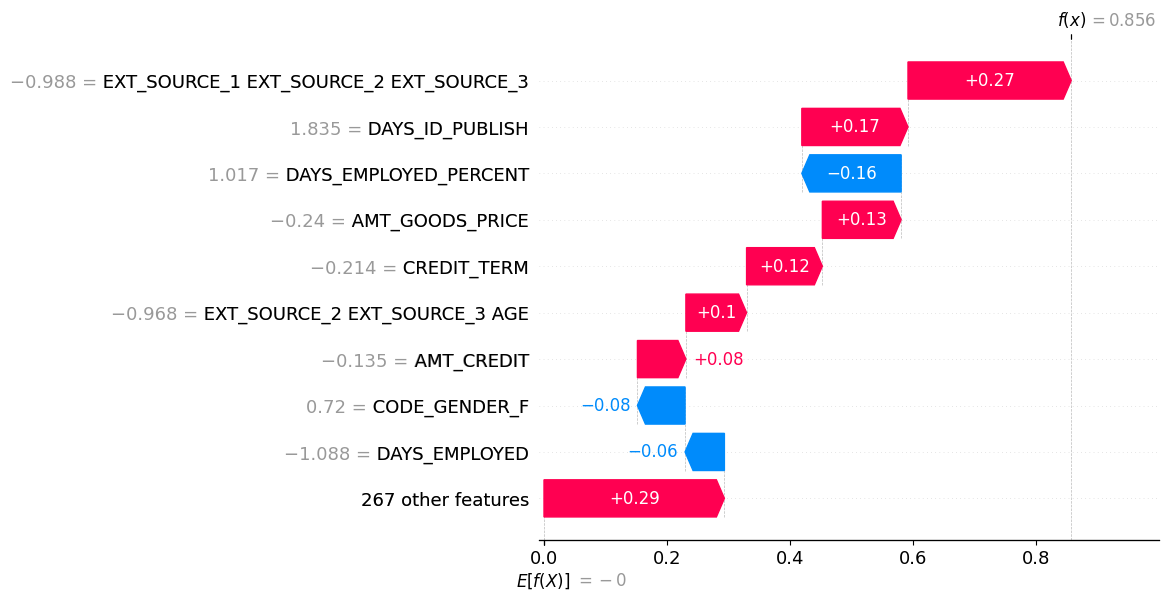

In [171]:
#  Choix d'un individu aléatoire pour l'explication locale
random_idx = np.random.randint(len(X_test_norm))
shap.waterfall_plot(shap_explainer_values[random_idx])

Pour ce deuxième individu, on peut voir que la prédiction finale est plus fortement influencée positivement par "les autres variables" (+0,29) ainsi que par la variable "EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3" (+0,27) qui a une valeur négative de -0,988 et a donc une influence positive comme vu dans l'explication globale au dessus.

Les influences négatives les plus importantes viennent de la variable "DAYS_EMPLOYED_PERCENT" (-0,16) qui a une valeur positive de 1,017 donc une influence négative comme montré dans l'explication globale.

La prédiction finale est positive (0,856) et tend à classifier cet individu dans la classe 1 des individus avec des difficultés de remboursement.

#### Limitations

Le fait que les variables "EXT_SOURCE" soient des scores normalisés dont on ne connait pas vraiment ni la source ni le contenu, ne permet pas d'aller plus loin en terme d'explicabilité "métier" du modèle.

**Ressources :**


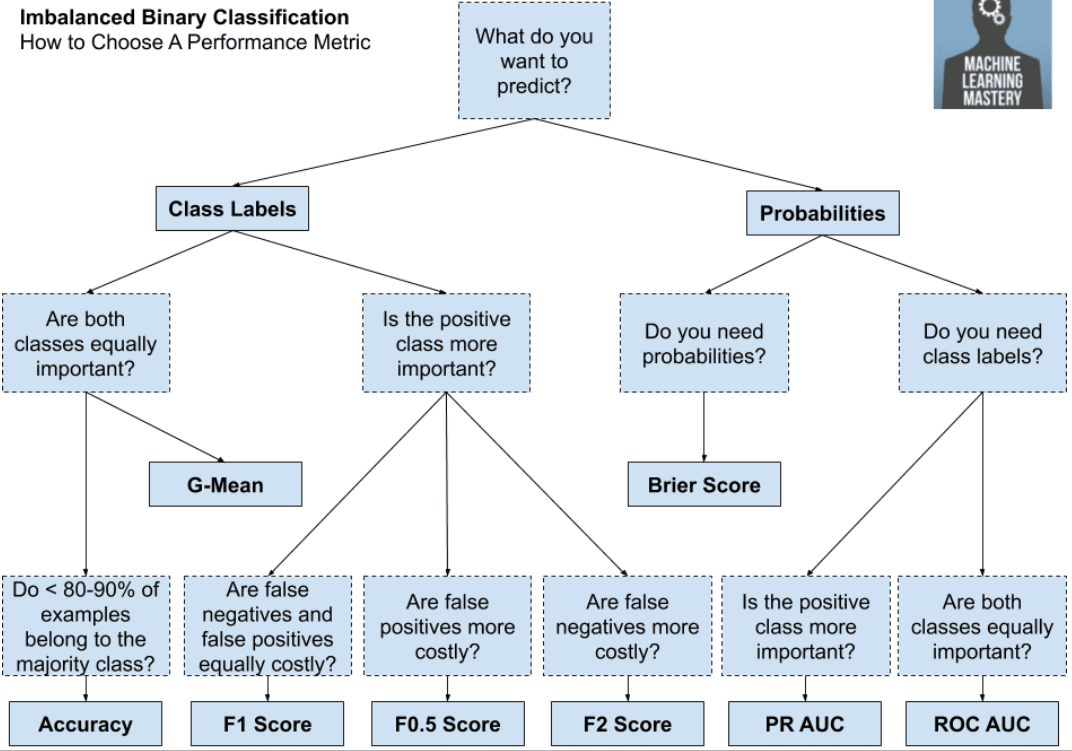

In [167]:
#  FONCTION PIPELINE

# EXEMPLE 1 :
# pipeline = Pipeline([
#     ('scaler', StandardScaler()),        #On normalise les données
#     ('pca', PCA(n_components=3)),        #On réduit la dimension
#     ('regressor', GradientBoostingRegressor(n_estimators=100,     learning_rate=0.1, max_depth=3, random_state=42))
# #On entraîne le modèle
# ])

# #On entraîne le modèle en utilisant le pipeline

# pipeline.fit(X_train, y_train)

# #Finalement, on évalue le modèle

# predictions = pipeline.predict(X_test)
# mse = mean_squared_error(y_test, predictions)
# print("Erreur quadratique moyenne :", mse)



# EXEMPLE 2 :
# pipe = Pipeline([
#     ('model', StandardScaler()),
#     ('model', DummyClassifier())
# ])

# grid = GridSearchCV(estimator=pipe,
#                     param_grid={'model__strategy': ['stratified', 'most_frequent', 'uniform']},
#                     cv=5,
#                     scoring={'acc': make_scorer(accuracy_score)},
#                     refit='acc',
#                     return_train_score=True)

# grid.fit(X, y)
# pd.DataFrame(grid.cv_results_)[['param_model__strategy', 'mean_test_acc']]